# BIM/BM25 기반 한국어 검색 시스템 구현 및 모델 비교 분석

2170045 컴퓨터공학과 서자영
---

In [49]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NLP-main/reports')
print("현재 작업 경로:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
현재 작업 경로: /content/drive/MyDrive/NLP-main/reports


## 1. 프로젝트 개요

본 프로젝트는 정보 검색(Information Retrieval)의 대표적인 확률 모델인 BIM(Binary Independence Model)과 BM25를 직접 구현하고, 한국어 데이터셋(KomuRetrieval)을 활용하여 두 모델의 성능 차이를 체계적으로 비교 분석한다. 검색 성능에 영향을 미치는 주요 변수들을 세 가지 회귀 분석 방법론—이진 로지스틱 회귀(Binary Logistic Regression), 다항 로지스틱 회귀(Multinomial Logistic Regression), 선형 다변량 회귀(Linear Multinomial Regression)—을 통해 정량적으로 분석하고, 각 변수의 통계적 유의성을 검증하였다.

### 1.1 연구 목표

1. **모델 비교**: BIM과 BM25의 한국어 검색 성능 비교 (MAP, P@10, R@10)
2. **세부 그룹 분석**: 문서 길이(Length), 토픽(Topic), 쿼리 복잡도(Complexity)별 성능 차이 검증
3. **통계적 검증**: 회귀 모델 구축을 통한 변수별 영향력 정량화 및 편향성 분석
4. **하이퍼파라미터 최적화**: BM25의 k1, b 파라미터 튜닝을 통한 한국어 데이터 최적화

### 1.2 개발 환경

- **언어**: Python 3.11.9
- **IDE**: IntelliJ IDEA
- **주요 라이브러리**:
  - `kiwipiepy`: 한국어 형태소 분석
  - `gensim`: LDA 토픽 모델링
  - `statsmodels`: 로지스틱 회귀 및 OLS 회귀 분석
  - `scikit-learn`: 데이터 분할 및 평가 지표
  - `SQLite`: 역색인 저장 및 검색


---

## 2. 데이터셋 및 실험 환경

### 2.1 데이터셋

- **Corpus**: KomuRetrieval 전체 50,222개 문서 중 5,000개 샘플링
- **Queries**: 1,454개 질의 집합
- **Qrels**: Query-Document 관련성 레이블

| Dataset | Count | Note |
|---------|-------|------|
| Full Corpus | 50,222 | Original |
| Sampled Corpus | 5,000 | Target (Smart Sampling) |
| Queries | 1,454 | Evaluation |
| Regression Pairs | 27,298 | Relevance Analysis |

### 2.2 스마트 샘플링 (Smart Sampling)

단순 무작위 추출 시 정답 문서가 누락되는 문제를 방지하기 위해, qrels에 포함된 문서를 우선 포함하는 전략을 사용하였다. 이를 통해 평가 가능한 쿼리 수를 최대화하고, 검색 성능 분석의 신뢰성을 확보하였다.


```
전체 문서: 50,222개
정답 포함 문서: 6,194개
최종 샘플: 5,000개 (정답 문서 우선 + 무작위)
```

### 2.3 데이터 전처리 및 불용어 처리

문서 길이를 유지하면서 검색 성능을 개선하기 위해, 다음과 같은 방법을 사용하였다.

#### 2.3.1 IDF 기반 불용어 선정

5,000개 문서 전체에서 Document Frequency(DF)가 높고 IDF < 1.5인 단어를 불용어로 지정하였다.

**불용어 추출 결과:**
- 총 고유 토큰 수: 157,022개
- IDF < 1.5 불용어: 346개

**불용어 예시 (상위 10개):**

| 순위 | 단어 | DF | IDF |
|-----|------|-----|-----|
| 1 | 나오 | 3,845 | 0.2627 |
| 2 | 보이 | 3,680 | 0.3065 |
| 3 | 이후 | 3,678 | 0.3071 |
| 4 | 정도 | 3,496 | 0.3578 |
| 5 | 위하 | 3,414 | 0.3816 |
| 6 | 경우 | 3,318 | 0.4101 |
| 7 | 사실 | 3,304 | 0.4143 |
| 8 | 사람 | 3,223 | 0.4391 |
| 9 | 만들 | 3,204 | 0.4450 |
| 10 | 시작 | 3,120 | 0.4716 |

**해석**: "나오", "보이" 등은 5,000개 문서 중 3,000개 이상에 등장하여 IDF가 0.26~0.47로 매우 낮아 검색 변별력이 없다.

#### 2.3.2 불용어/반복 특수문자/단일 자모음 패딩 처리

불용어를 삭제하지 않고 글자 수만큼 'O'로 치환하여 문서 길이를 보존하였다. (e.g. "나오다" -> OOO) 반복되는 특수문자(`!!!!`, `......`)와 한글 자모음(`ㅋㅋㅋ`, `ㅠㅠㅠ`)도 동일하게 'O'로 패딩 처리하였다. 이는 BIM과 BM25 모델이 문서 길이에 민감하게 반응하기 때문에 매우 중요하다.

### 2.4 문서 특성 추출

나무위키 데이터셋 특성상 문서 길이의 편차가 매우 크다. 이는 BM25의 길이 정규화 파라미터(b) 설정에 중요한 근거가 된다. Kiwi 형태소 분석기를 사용하여 각 문서의 언어학적 특성을 추출하였다.

| 특성 | 평균 | 중앙값 | 최소 | 최대 |
|------|------|--------|------|------|
| 문서 길이 (doc_length) | 7,873.0 | 4,366 | 0 | 102,419 |
| 형태소 개수 | 5,053.2 | 2,777 | 0 | - |
| 음절 수 | 7,514.7 | 4,174 | 0 | - |
| 문장 개수 | 154.0 | 86 | 0 | - |
| 평균 문장 길이 | 55.7 | 47 | 0 | - |

**주요 발견:**
- 문서 길이 편차가 매우 큼 (최소 0 ~ 최대 102,419자)
- 평균 문장 길이: 55.7 음절 (중앙값 47)
- 이러한 길이 분포가 BIM/BM25 성능 차이의 주요 원인

### 2.5 LDA 토픽 모델링

Gensim LdaModel을 사용하여 문서를 10가지 거시적 주제로 분류하였다.

**LDA 토픽 분포:**

| Topic ID | Count | Percent | Keywords |
|----------|-------|---------|----------|
| 0 | 679 | 13.6% | 역사/정치 |
| 1 | 822 | 16.4% | 일상/감정 |
| 2 | 295 | 5.9% | 스포츠/리그 |
| 3 | 391 | 7.8% | 사회/이슈 |
| 4 | 445 | 8.9% | 국제/외교 |
| 5 | 847 | 16.9% | 게임/RPG |
| 6 | 503 | 10.1% | 전쟁/역사 |
| 7 | 204 | 4.1% | 마인크래프트 |
| 8 | 538 | 10.8% | 방송/연예 |
| 9 | 276 | 5.5% | 교통/도시 |

**주요 토픽:**
- Topic 5 (게임/스킬, 16.9%)
- Topic 1 (일상/감정, 16.4%)
- Topic 0 (역사/정치, 13.6%)

분포가 특정 주제에 치우치지 않고 비교적 고르게 나타났다.

---

## 3. 시스템 구현

### 3.1 역색인 구축

SQLite를 사용하여 대용량 데이터 처리와 메모리 효율성을 동시에 확보하였다.


**데이터베이스 스키마:**
```sql
CREATE TABLE inverted_index (
term TEXT,
doc_id TEXT,
tf INTEGER
);
CREATE INDEX idx_term ON inverted_index(term);
```

**구축 과정:**
1. 각 문서를 토큰화하여 TF(Term Frequency) 계산
2. 패딩 토큰('O'만으로 구성된 토큰) 제외
3. 배치 커밋(50,000개 단위)으로 I/O 최적화

### 3.2 BM25 하이퍼파라미터 튜닝

BM25의 k1(TF saturation)과 b(length normalization) 파라미터를 Grid Search를 통해 MAP 기준으로 최적화하였다.

**튜닝 전략:**

**1차 탐색 (Coarse Grid):**
- k1: [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
- b: [0.6, 0.7, 0.8, 0.9, 0.99]
- 총 35회 실험
- 결과: k1=3.0, b=0.99, MAP=0.6305

**2차 탐색 (Fine Grid):**
- k1: [2.5, 2.75, 3.0, 3.25, 3.5] (±0.5 범위, 0.25 간격)
- b: [0.89, 0.94, 0.99] (±0.1 범위, 0.05 간격)
- 총 15회 실험
- 최종: k1=3.25, b=0.99, MAP=0.6309

In [50]:
import os
import pandas as pd
import numpy as np
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = os.path.join('..')
DATA_DIR = os.path.join(BASE_DIR, 'data_final')

tuning_coarse_path = os.path.join(DATA_DIR, 'tuning_coarse_v2.csv')
if os.path.exists(tuning_coarse_path):
    df_tuning_coarse = pd.read_csv(tuning_coarse_path)
    print("\n[1차 탐색 상세 결과]")
    display(df_tuning_coarse.head(10))

tuning_fine_path = os.path.join(DATA_DIR, 'tuning_fine_v2.csv')
if os.path.exists(tuning_fine_path):
    df_tuning_fine = pd.read_csv(tuning_fine_path)
    print("\n[2차 탐색 상세 결과]")
    display(df_tuning_fine)


[1차 탐색 상세 결과]


,k1,b,MAP
0,2.0,0.60,0.604511
1,2.0,0.70,0.611607
2,2.0,0.80,0.619449
3,2.0,0.90,0.625556
4,2.0,0.99,0.627744
5,2.5,0.60,0.606648
6,2.5,0.70,0.614600
7,2.5,0.80,0.620384
8,2.5,0.90,0.626270
9,2.5,0.99,0.629283



[2차 탐색 상세 결과]


,k1,b,MAP
0,2.50,0.89,0.626547
1,2.50,0.94,0.628715
2,2.50,0.99,0.629283
3,2.75,0.89,0.627126
4,2.75,0.94,0.630104
5,2.75,0.99,0.629780
6,3.00,0.89,0.627705
7,3.00,0.94,0.630299
8,3.00,0.99,0.630534
9,3.25,0.89,0.628346



**최종 채택 파라미터:**
- **k1 = 3.25** (TF 포화도)
- **b = 0.99** (길이 정규화 강도)

**해석:**
- **b=0.99**: 문서 길이 정규화를 최대로 적용. 길이가 긴 문서가 단순히 단어가 많아서 점수가 높아지는 것을 강력하게 억제한다.
- **k1=3.25**: 단어 빈도(TF) 증가에 따른 점수 상승 폭을 완만하게 설정하여 키워드 반복(Spam) 효과를 제어한다.

이는 한국어 나무위키 문서의 길이 편차가 크다는 특성을 정확히 반영한다.

---

## 4. 통계적 분석 1: 전역 회귀 분석 (Global Regression Analysis)

전체 27,298개 데이터 쌍에 대해 세 가지 회귀 분석을 수행하여 변수의 전역적 영향력을 다각도로 분석하였다.

### 4.1 변수 정의 및 다중공선성 진단

검색 성공 여부 또는 검색 점수를 종속변수로, 다음 3개 독립변수를 선정하였다.

- **x1 (a1)**: `doc_length_scaled` - 문서 길이 / 1000 (1k 단위로 스케일링)
- **x2 (a2)**: `query_length_scaled` - 쿼리 길이 (형태소 개수)
- **x3 (a3)**: `dominant_topic` - 문서의 주도 토픽 (0~9)

In [51]:
vif_full_path = os.path.join(DATA_DIR, 'vif_full_v2.csv')
if os.path.exists(vif_full_path):
    df_vif_full = pd.read_csv(vif_full_path)
    print("[다중공선성 진단 - 전체 변수]")
    display(df_vif_full)
    print("\nVIF > 10: 다중공선성 심각")

[다중공선성 진단 - 전체 변수]


,Feature,VIF
0,query_unique_ratio,56.123630
1,query_length,28.299857
2,query_avg_token_len,28.275001
3,query_match_count,24.817168
4,query_match_ratio,17.497113
5,dominant_prob,12.335673
6,dominant_topic,3.112434
7,doc_length,2.531132



VIF > 10: 다중공선성 심각


초기 분석에서 쿼리 관련 변수들이 강한 상관관계를 보였다. 이러한 변수들을 제외하고 최종 변수를 선정했다.

In [52]:
vif_final_path = os.path.join(DATA_DIR, 'vif_final_v2.csv')
if os.path.exists(vif_final_path):
    df_vif_final = pd.read_csv(vif_final_path)
    print("\n[최종 변수 VIF]")
    display(df_vif_final)
    print("\n모든 변수가 VIF < 3으로 다중공선성 문제 없음")


[최종 변수 VIF]


,Feature,VIF
0,doc_length_scaled,2.151800
1,query_length_scaled,2.761771
2,dominant_topic,2.186296



모든 변수가 VIF < 3으로 다중공선성 문제 없음


### 4.2 이진 로지스틱 회귀 (Binary Logistic Regression)

관련성(relevance: 0 또는 1)을 종속변수로 하는 로지스틱 회귀를 수행하여 Odds Ratio를 계산하였다.

#### 회귀 모델

```
logit(P(relevance=1)) = β0 + α1*doc_length + α2*query_length + Σα3_i*topic_i
```

#### 모델 성능

| 모델 | Pseudo R² | AIC | Doc Length OR (a1) | Query Length OR (a2) |
|------|-----------|-----|-------------------|---------------------|
| BIM | 0.2344 | 10,296 | 0.8949 *** | 1.0690 *** |
| BM25 | 0.0161 | 15,722 | 1.0086 *** | 1.0329 *** |

#### Odds Ratio

In [53]:
odds_path = os.path.join(DATA_DIR, 'odds_ratio_v2.csv')
if os.path.exists(odds_path):
    df_odds = pd.read_csv(odds_path)

    print("[주요 변수 Odds Ratio]")
    main_vars = df_odds[df_odds['Feature'].isin(['doc_length_scaled', 'query_length_scaled'])]
    display(main_vars[['Model', 'Feature', 'Odds_Ratio', 'P_value', 'Lower_CI', 'Upper_CI']])

    print("\n[토픽별 Odds Ratio (유의미한 토픽만)]")
    topic_vars = df_odds[df_odds['Feature'].str.startswith('topic_')]
    significant_topics = topic_vars[topic_vars['P_value'] < 0.05]
    display(significant_topics[['Model', 'Feature', 'Odds_Ratio', 'P_value', 'Lower_CI', 'Upper_CI']])

[주요 변수 Odds Ratio]


,Model,Feature,Odds_Ratio,P_value,Lower_CI,Upper_CI
0,BIM,doc_length_scaled,0.894886,0.000000e+00,0.889893,0.899908
1,BIM,query_length_scaled,1.068998,3.541750e-87,1.061958,1.076085
11,BM25,doc_length_scaled,1.008643,3.985714e-05,1.004510,1.012793
12,BM25,query_length_scaled,1.032899,1.520381e-34,1.027567,1.038259



[토픽별 Odds Ratio (유의미한 토픽만)]


,Model,Feature,Odds_Ratio,P_value,Lower_CI,Upper_CI
2,BIM,topic_1,1.289054,6.227489e-03,1.074643,1.546243
4,BIM,topic_3,1.663699,2.028610e-06,1.348543,2.052509
5,BIM,topic_4,1.315817,8.203002e-03,1.073554,1.612751
7,BIM,topic_6,1.636525,7.387102e-07,1.346588,1.988888
8,BIM,topic_7,1.625563,3.387518e-04,1.246246,2.120331
10,BIM,topic_9,1.411862,2.642362e-03,1.127568,1.767836
13,BM25,topic_1,1.283480,6.887655e-04,1.111212,1.482455
15,BM25,topic_3,1.496474,4.594502e-06,1.259479,1.778063
16,BM25,topic_4,1.308493,1.391630e-03,1.109607,1.543027
18,BM25,topic_6,1.302402,1.033986e-03,1.112250,1.525062



[Odds Ratio 시각화]


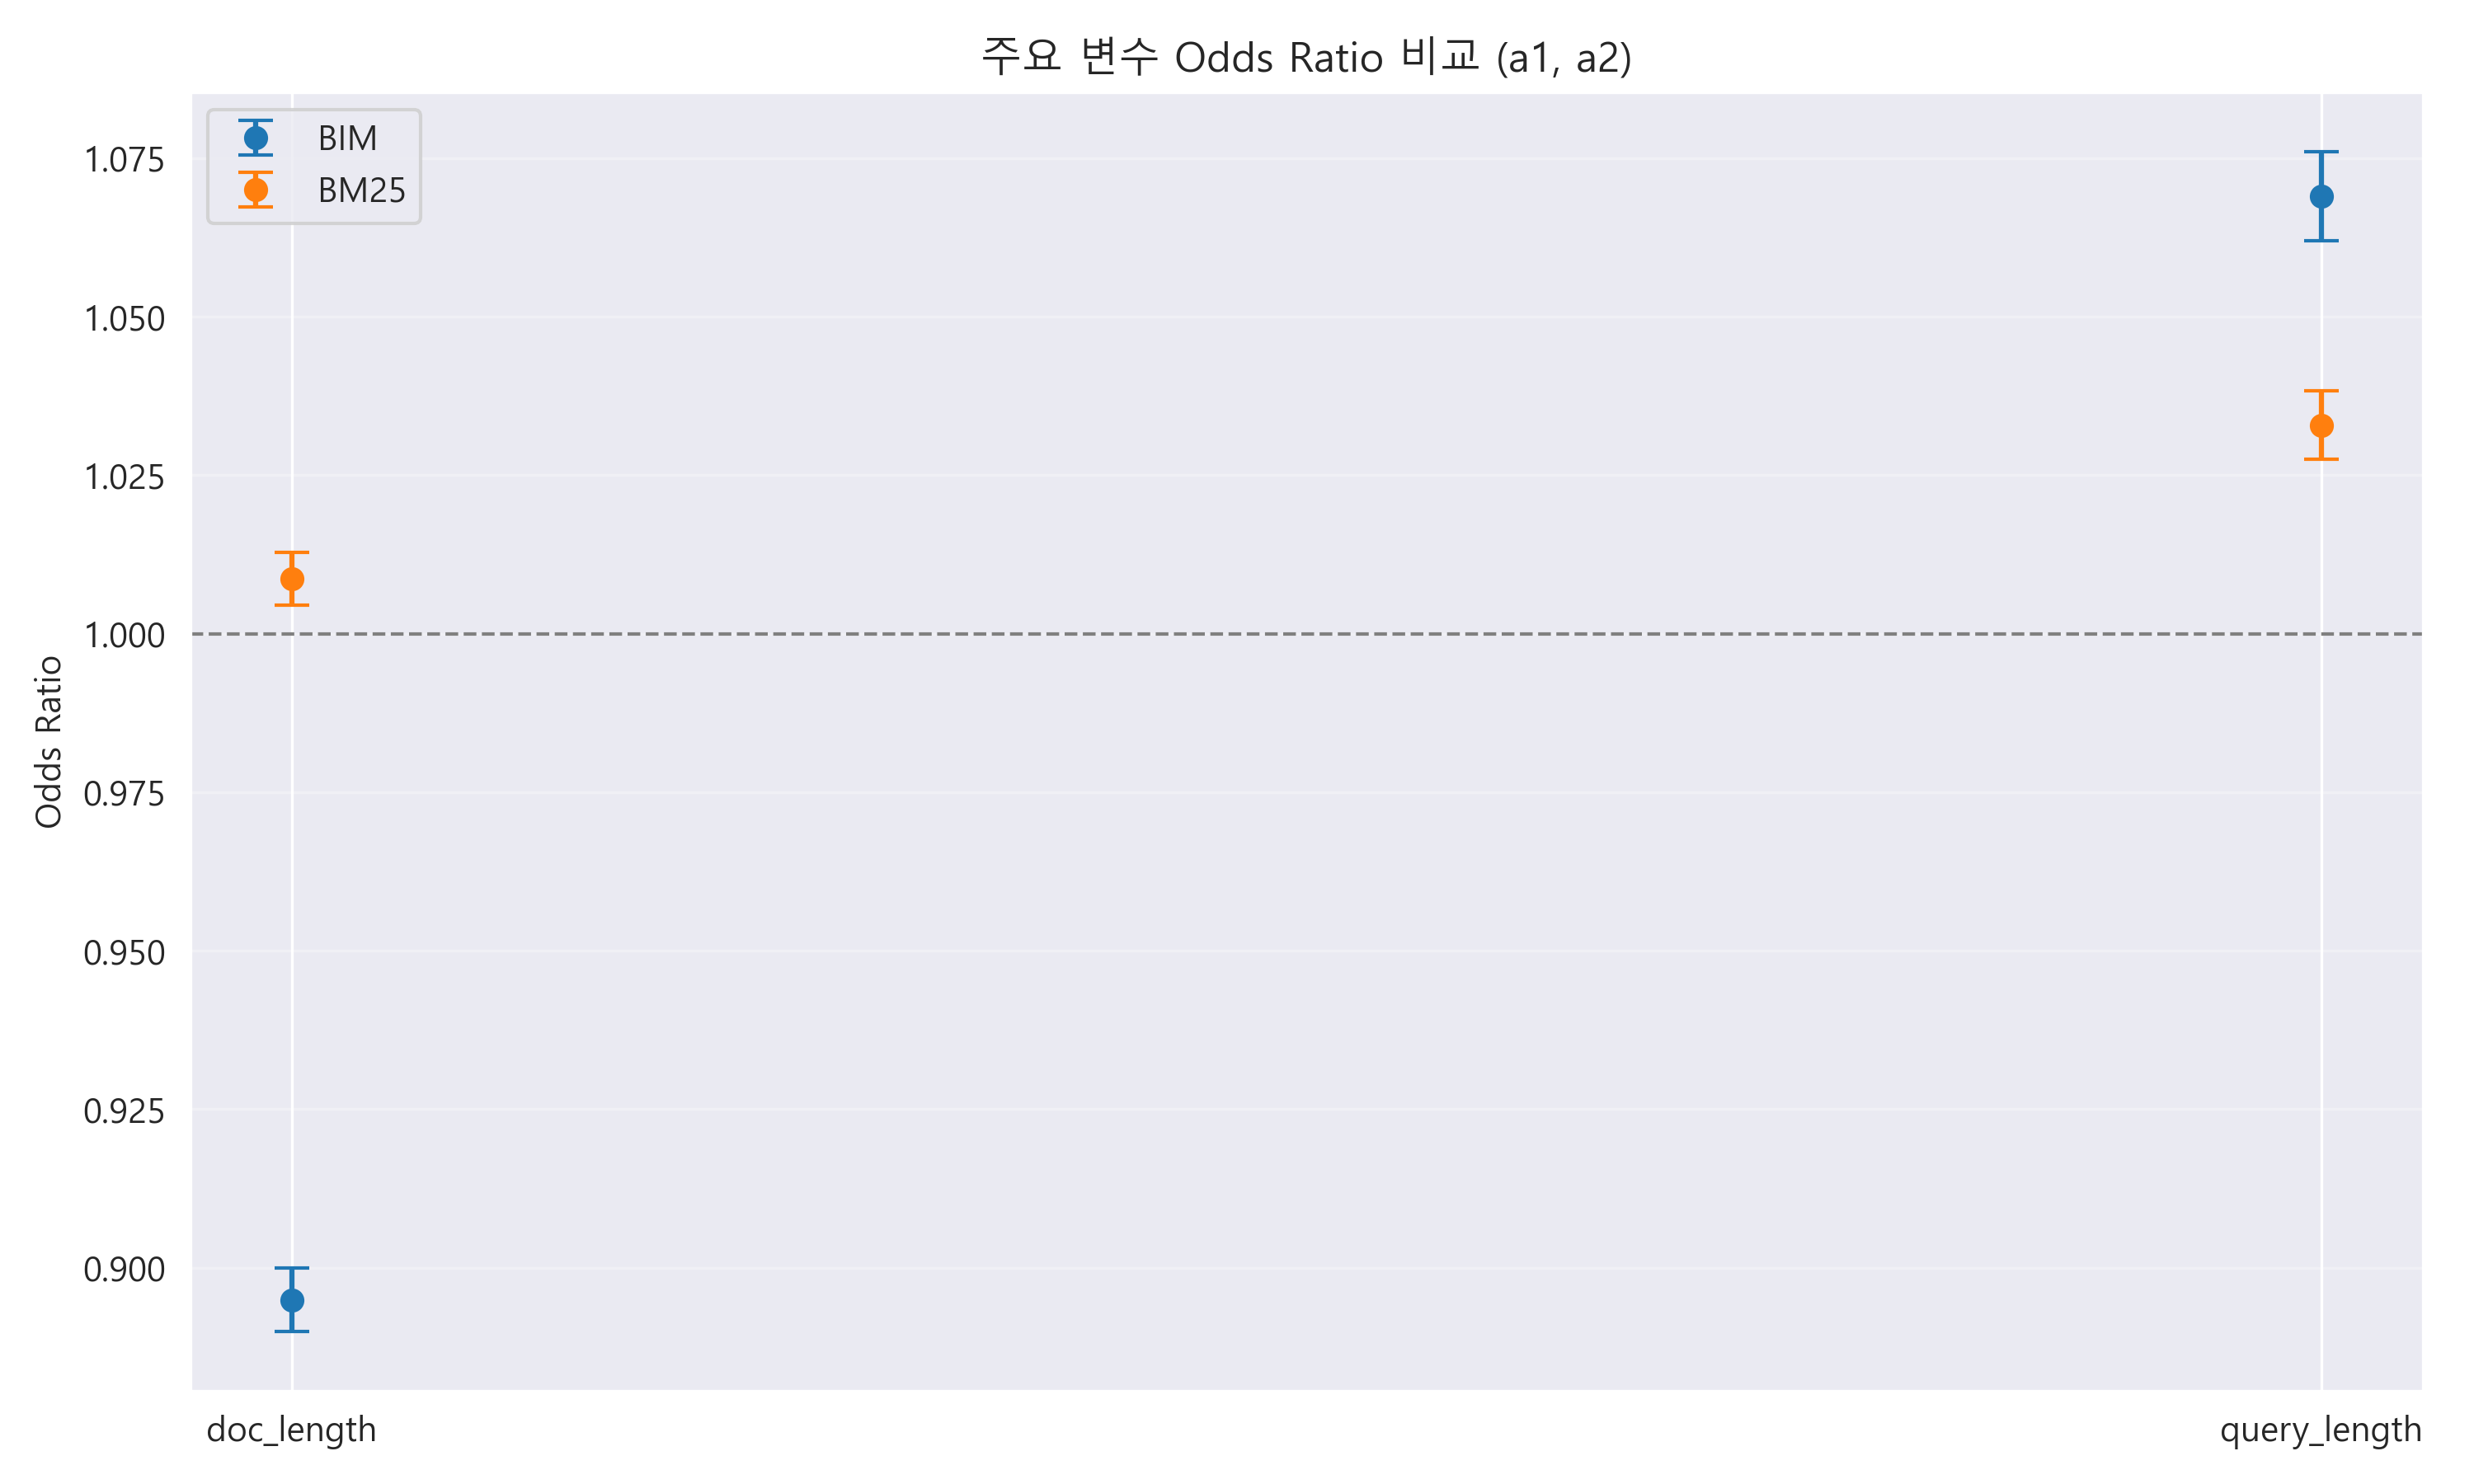

In [54]:
odds_comparison_img = os.path.join(DATA_DIR, 'odds_ratio_comparison_v2.png')
if os.path.exists(odds_comparison_img):
    print("\n[Odds Ratio 시각화]")
    display(Image(odds_comparison_img))


**a1 (문서 길이):**
- **BIM**: OR=0.89 → 문서 1,000자 증가 시 성공 확률 11% **감소** (짧은 문서 편향)
- **BM25**: OR=1.01 → 문서 1,000자 증가 시 성공 확률 0.86% **증가** (거의 중립적, 편향 없음)

**a2 (쿼리 길이):**
- **BIM**: OR=1.07 → 형태소 1개 증가 시 성공 확률 6.9% 증가
- **BM25**: OR=1.03 → 형태소 1개 증가 시 성공 확률 3.3% 증가
- 둘 다 긍정적이지만 BIM이 더 민감함

**a3 (도메인/토픽):**

주요 토픽별 Odds Ratio (BIM):

| Topic | OR | 95% CI | P-value |
|-------|-----|--------|---------|
| Topic 3 | 1.6637 | [1.3485, 2.0525] | < 0.001 |
| Topic 6 | 1.6365 | [1.3466, 1.9889] | < 0.001 |
| Topic 7 | 1.6256 | [1.2462, 2.1203] | < 0.001 |

주요 토픽별 Odds Ratio (BM25):

| Topic | OR | 95% CI | P-value |
|-------|-----|--------|---------|
| Topic 3 | 1.4965 | [1.2595, 1.7781] | < 0.001 |
| Topic 7 | 1.3792 | [1.1140, 1.7076] | 0.003 |

Topic 3, 6, 7이 두 모델 모두에서 OR > 1.3으로 높음 (유리한 도메인). BIM과 BM25의 토픽별 OR 패턴이 유사하여 도메인 효과는 모델 독립적임을 보여준다.


#### Pseudo R² 해석

- **BIM**: 0.23 → 길이 변수만으로 23% 설명 가능 (길이 의존도 높음)
- **BM25**: 0.016 → 길이 변수만으로 1.6%만 설명 가능 (길이 정규화 성공)

**BIM의 높은 Pseudo R²는 역설적으로 편향을 의미한다.** 단순히 문서 길이 같은 외적 변수로 검색 성공을 예측할 수 있다는 것은 모델이 내용보다 형식에 의존한다는 증거이다.


#### 검색 성능 비교


In [55]:
summary_path = os.path.join(DATA_DIR, 'summary_metrics_v2.csv')
if os.path.exists(summary_path):
    df_summary = pd.read_csv(summary_path)
    print("[모델별 성능 요약]")
    display(df_summary)

[모델별 성능 요약]


,Model,MAP,MAP_std,P@10,P@10_std,R@10,R@10_std,Pseudo_R2,Best_AUC
0,BIM,0.416477,0.343109,0.192638,0.189120,0.520456,0.375584,0.234355,0.828619
1,BM25_Best,0.630858,0.325391,0.269825,0.223543,0.681041,0.314312,0.016088,0.579053



[성능 비교 시각화]


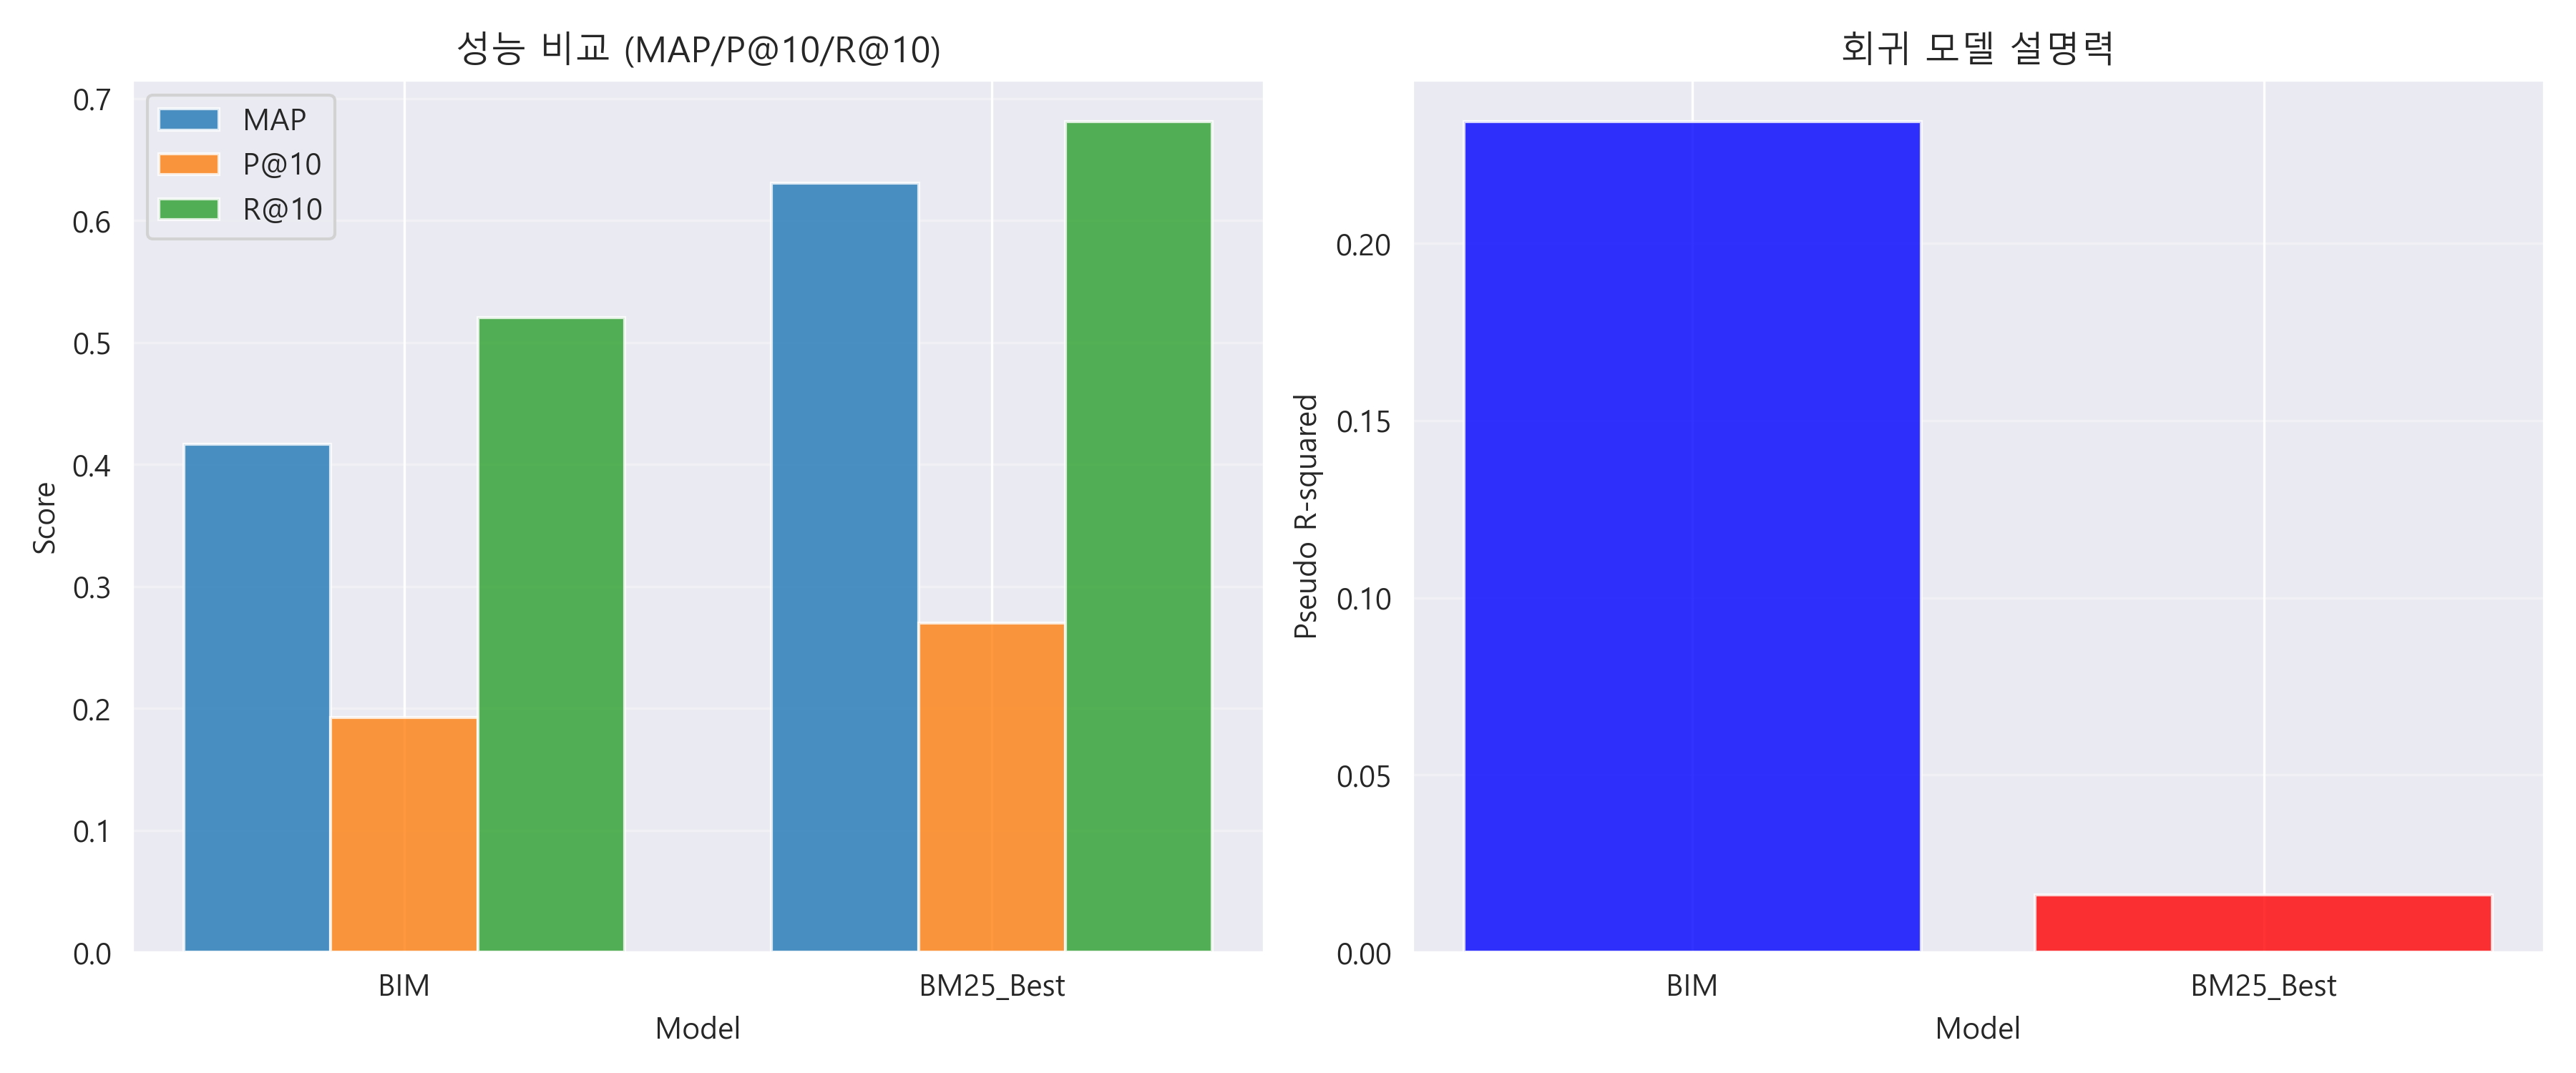

In [56]:
perf_comparison_img = os.path.join(DATA_DIR, 'performance_comparison_v2.png')
if os.path.exists(perf_comparison_img):
    print("\n[성능 비교 시각화]")
    display(Image(perf_comparison_img))


| 지표 | BIM | BM25 | 개선율 |
|------|-----|------|--------|
| MAP | 0.416 ± 0.343 | 0.631 ± 0.325 | +51.5% |
| P@10 | 0.193 ± 0.189 | 0.270 ± 0.224 | +40.0% |
| R@10 | 0.520 ± 0.376 | 0.681 ± 0.314 | +31.0% |
| Pseudo R² | 0.234 | 0.016 | (낮을수록 편향 없음) |
| Best AUC | 0.829 | 0.579 | (낮을수록 편향 없음) |

**종합 해석:**
- 검색 성능 (MAP/P@10/R@10): BM25가 모든 지표에서 압도적 우위
- Pseudo R²: BIM 높음(0.23) = 길이만으로 예측 가능 = 편향
- Best AUC: BIM 높음(0.83) = 길이 편향으로 성공 예측 가능 = 불공정
- 표준편차: BM25가 더 낮아 안정적


### 4.3 가중치 튜닝 (Manual Linear Scoring)

로지스틱 회귀는 가중치를 자동으로 조정하므로, 수동 가중치 튜닝을 통해 각 변수의 실제 영향력을 검증하였다.

#### 방법

```
Score = w1·x1 + w2·x2 + w3·x3
```

- 변수 표준화 후 AUC로 평가
- 가중치 후보: w1=[-2.0 ~ 3.0], w2=[0.0 ~ 3.0], w3=[0.0 ~ 2.0]
- 총 270개 조합 탐색

In [57]:
weight_tuning_path = os.path.join(DATA_DIR, 'weight_tuning_v2.csv')
if os.path.exists(weight_tuning_path):
    df_tuning = pd.read_csv(weight_tuning_path)

    print("[BIM 최적 가중치]")
    bim_top = df_tuning[df_tuning['model']=='BIM'].sort_values('AUC', ascending=False).head(5)
    display(bim_top)

    print("\n[BM25 최적 가중치]")
    bm25_top = df_tuning[df_tuning['model']=='BM25_Best'].sort_values('AUC', ascending=False).head(5)
    display(bm25_top)

[BIM 최적 가중치]


,model,w1_doc,w2_query,w3_topic,AUC
5,BIM,-2.0,0.5,0.0,0.828619
6,BIM,-2.0,0.5,0.5,0.817355
30,BIM,-1.0,0.0,0.0,0.813636
0,BIM,-2.0,0.0,0.0,0.813636
60,BIM,-0.5,0.0,0.0,0.813636



[BM25 최적 가중치]


,model,w1_doc,w2_query,w3_topic,AUC
445,BM25_Best,1.0,3.0,0.0,0.579053
405,BM25_Best,0.5,1.5,0.0,0.579053
410,BM25_Best,0.5,2.0,0.0,0.578951
475,BM25_Best,1.5,3.0,0.0,0.578825
440,BM25_Best,1.0,2.0,0.0,0.578825



[가중치 히트맵]


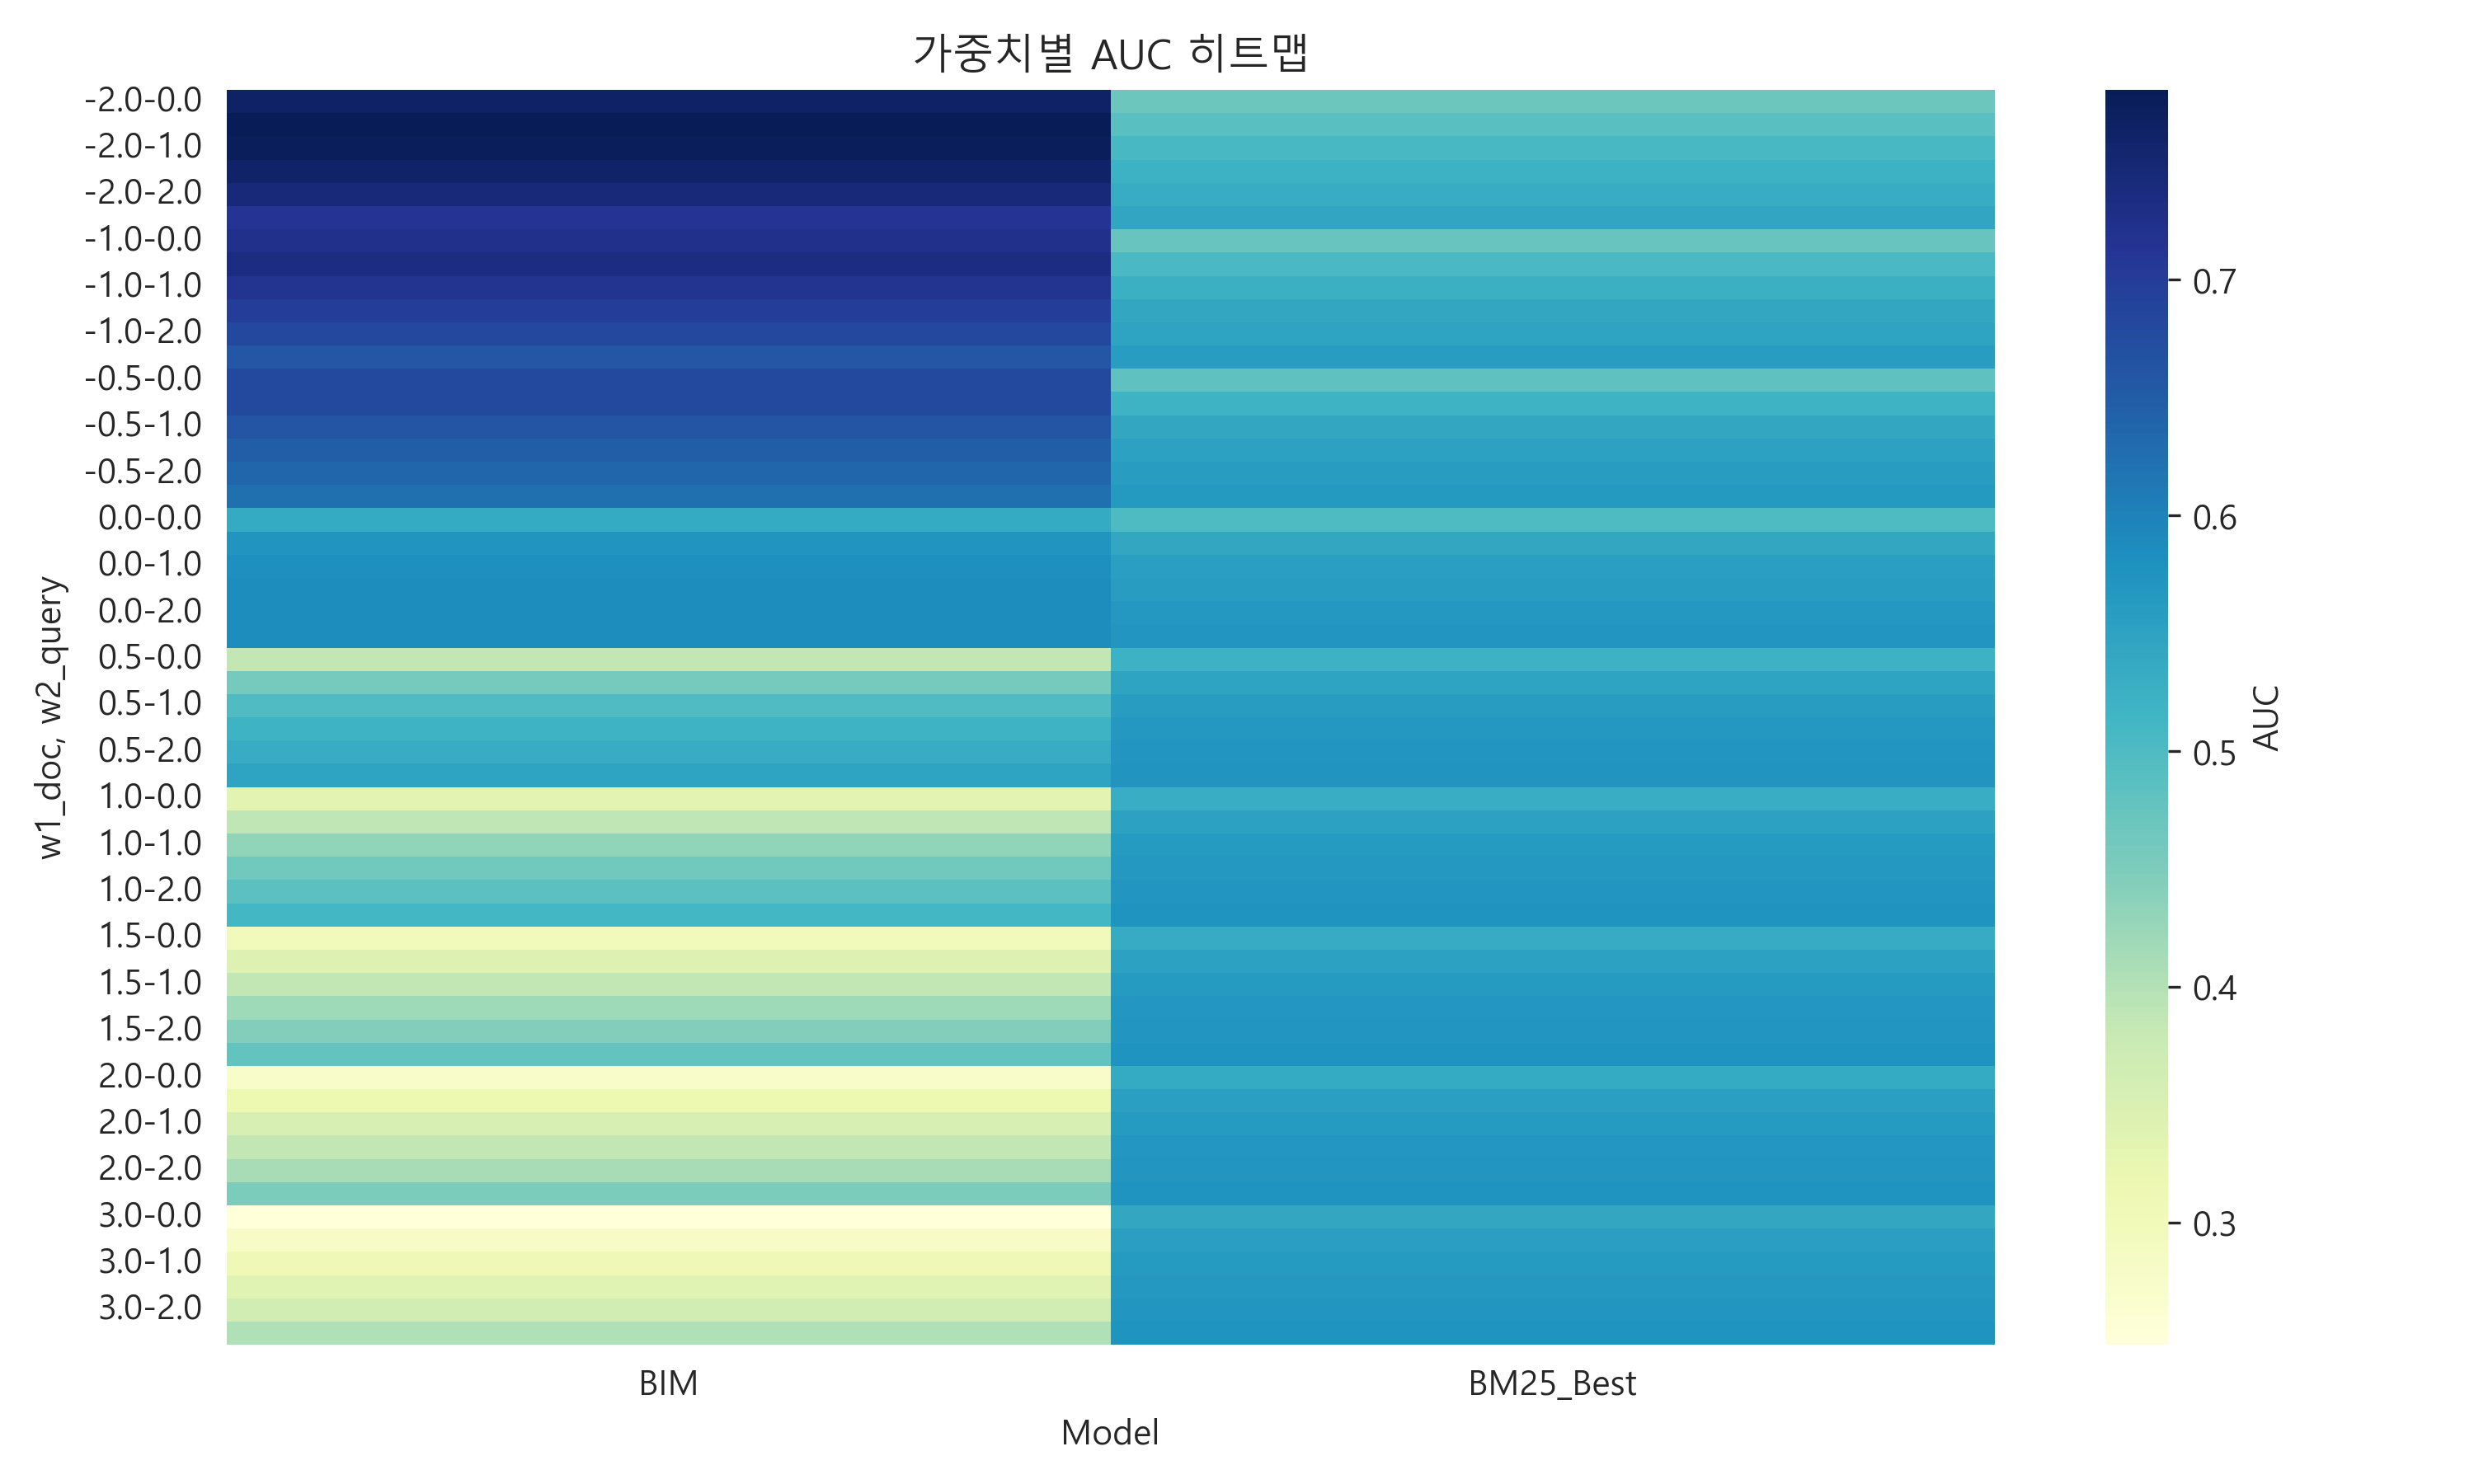

In [58]:
weight_heatmap_img = os.path.join(DATA_DIR, 'weight_heatmap_v2.png')
if os.path.exists(weight_heatmap_img):
    print("\n[가중치 히트맵]")
    display(Image(weight_heatmap_img))

**핵심 해석:**

**BIM:**
- w1=-2.0 (문서 길이에 음수 가중치) → 짧은 문서 극단적 편향
- w3=0.0 (토픽 무시)
- AUC=0.83 → **높은 AUC = 편향이 심하다는 증거**

**BM25:**
- w1=1.0 (문서 길이 긍정, 중립적)
- w2=3.0 (쿼리 길이 강조)
- w3=0.0 (토픽 무시)
- AUC=0.58 → **낮은 AUC = 길이 편향 없음 = 공정함**

**w3=0.0의 의미:**
- 두 모델 모두 토픽 가중치가 0으로 수렴
- 토픽 정보는 관련성(0/1) 판단에 기여하지 않음
- 이유는 섹션 6에서 케이스 분석을 통해 상세히 규명

### 4.4 선형 다변량 회귀 (Linear Multinomial Regression)

검색 점수(search_score) 자체를 종속변수로 하는 다중 선형 회귀를 수행하여 각 변수가 점수에 미치는 직접적인 영향을 정량화하였다. 토픽은 더미 변수(dummy variables)로 변환하여 각 토픽의 개별 효과를 측정하였다.

#### 회귀 모델

```
y = a1*x1 + a2*x2 + a3_1*topic1 + a3_2*topic2 + ... + a3_9*topic9 + b
```

topic 0을 기준(reference)으로 설정하고, topic 1~9의 상대적 효과를 측정한다.

In [59]:
linear_results_path = os.path.join(DATA_DIR, 'linear_regression_results_v5.csv')
if os.path.exists(linear_results_path):
    df_linear = pd.read_csv(linear_results_path)
    print("[Linear Regression 모델 성능]")
    display(df_linear)

[Linear Regression 모델 성능]


,Model,a1_doc,a2_query,b_intercept,Train_R2,Test_R2,Test_MSE,Test_MAE,Adj_R2,F_stat,F_pvalue,AIC,BIC
0,BIM,-0.025779,0.688940,4.713599,0.497314,0.501214,24.756474,3.661936,0.496807,980.950867,0.0,66435.709391,66523.288507
1,BM25_Best,0.058958,1.322078,9.629807,0.252502,0.261928,281.091867,12.086784,0.251748,334.940316,0.0,93042.995584,93130.574700


#### 회귀 계수

In [60]:
linear_stats_path = os.path.join(DATA_DIR, 'linear_regression_stats_v5.csv')
if os.path.exists(linear_stats_path):
    df_linear_stats = pd.read_csv(linear_stats_path)
    print("\n[회귀 계수 및 통계적 유의성]")
    display(df_linear_stats)


[회귀 계수 및 통계적 유의성]


,Model,Variable,Coefficient,Std_Error,T_statistic,P_value,CI_Lower,CI_Upper
0,BIM,a1_doc_length,-0.025779,0.002456,-10.494654,1.210935e-25,-0.030594,-0.020964
1,BIM,a2_query_length,0.688940,0.006695,102.906732,0.000000e+00,0.675817,0.702063
2,BM25_Best,a1_doc_length,0.058958,0.018517,3.183970,1.456781e-03,0.022661,0.095255
3,BM25_Best,a2_query_length,1.322078,0.022644,58.386048,0.000000e+00,1.277692,1.366464


**a1 (문서 길이):**

| 모델 | 계수 | Std Error | t-stat | P-value | 95% CI |
|------|------|-----------|--------|---------|---------|
| BIM | -0.0258 | 0.0025 | -10.49 | < 0.001 | [-0.0306, -0.0210] |
| BM25 | +0.0590 | 0.0185 | +3.18 | 0.001 | [+0.0227, +0.0953] |

**해석:**
- **BIM**: 문서 1,000자 증가 시 검색 점수 0.026 **감소** → 짧은 문서를 선호하는 구조적 편향
- **BM25**: 문서 1,000자 증가 시 검색 점수 0.059 **증가** → 긴 문서가 더 많은 정보를 포함할 가능성 반영

**Binary Logistic(OR=1.01)과의 일관성:** BM25는 관련성 판단(OR=1.01)에서 거의 중립적이면서, 검색 점수 자체는 문서 길이에 따라 약간 증가한다. 이는 긴 문서의 정보량 이점은 인정하되, 길이만으로 관련성을 판단하지 않는다는 의미이다.

**a2 (쿼리 길이):**

| 모델 | 계수 | Std Error | t-stat | P-value | 95% CI |
|------|------|-----------|--------|---------|---------|
| BIM | +0.6889 | 0.0067 | +102.91 | < 0.001 | [+0.6758, +0.7021] |
| BM25 | +1.3221 | 0.0226 | +58.39 | < 0.001 | [+1.2777, +1.3665] |

**해석:**
- 두 모델 모두 쿼리가 길수록 검색 점수 증가
- BM25(+1.32)가 BIM(+0.69)보다 약 2배 민감
- BM25는 긴 쿼리의 정보를 더 효과적으로 활용함

In [61]:
linear_topic_path = os.path.join(DATA_DIR, 'linear_regression_topic_coefs_v5.csv')
if os.path.exists(linear_topic_path):
    df_topic_coefs = pd.read_csv(linear_topic_path)

    print("[BIM 토픽 계수 (유의미한 토픽만)]")
    bim_topics = df_topic_coefs[(df_topic_coefs['Model'] == 'BIM') & (df_topic_coefs['P_value'] < 0.05)]
    bim_topics_sorted = bim_topics.sort_values('Coefficient', ascending=False)
    display(bim_topics_sorted[['Topic', 'Coefficient', 'P_value', 'CI_Lower', 'CI_Upper']])

    print("\n[BM25 토픽 계수 (유의미한 토픽만)]")
    bm25_topics = df_topic_coefs[(df_topic_coefs['Model'] == 'BM25_Best') & (df_topic_coefs['P_value'] < 0.05)]
    bm25_topics_sorted = bm25_topics.sort_values('Coefficient', ascending=False)
    display(bm25_topics_sorted[['Topic', 'Coefficient', 'P_value', 'CI_Lower', 'CI_Upper']])

[BIM 토픽 계수 (유의미한 토픽만)]


,Topic,Coefficient,P_value,CI_Lower,CI_Upper
1,2,1.689459,4.042473e-14,1.251972,2.126946
6,7,1.660014,2.151355e-09,1.116878,2.203150
2,3,1.088061,4.408810e-07,0.666015,1.510107
5,6,1.067667,3.187109e-08,0.689550,1.445785
7,8,0.685528,2.367866e-04,0.320114,1.050941
8,9,0.586627,1.484413e-02,0.114691,1.058563



[BM25 토픽 계수 (유의미한 토픽만)]


,Topic,Coefficient,P_value,CI_Lower,CI_Upper
15,7,6.900711,1.671712e-13,5.068351,8.733070
10,2,5.308710,1.229248e-11,3.774808,6.842612
11,3,3.822998,5.281812e-07,2.329856,5.316141
14,6,3.264229,2.109154e-06,1.915826,4.612632
17,9,3.062337,1.216820e-04,1.500792,4.623882
13,5,1.803054,1.784266e-03,0.671981,2.934127
16,8,1.718349,6.796504e-03,0.474144,2.962554




**a3 (토픽 효과):**

토픽을 더미 변수로 변환하여 각 토픽이 검색 점수에 미치는 영향을 개별적으로 측정하였다. Topic 0을 기준으로, 각 토픽의 상대적 효과를 나타낸다.

**BIM 토픽 계수 (유의미한 토픽만):**

| Topic | 계수 | P-value | 해석 |
|-------|------|---------|------|
| Topic 7 | +1.6600 | < 0.001 | Topic 0 대비 1.66점 높음 |
| Topic 2 | +1.6895 | < 0.001 | Topic 0 대비 1.69점 높음 |
| Topic 3 | +1.0881 | < 0.001 | Topic 0 대비 1.09점 높음 |
| Topic 6 | +1.0677 | < 0.001 | Topic 0 대비 1.07점 높음 |
| Topic 8 | +0.6855 | < 0.001 | Topic 0 대비 0.69점 높음 |
| Topic 9 | +0.5866 | 0.015 | Topic 0 대비 0.59점 높음 |

**BM25 토픽 계수 (유의미한 토픽만):**

| Topic | 계수 | P-value | 해석 |
|-------|------|---------|------|
| Topic 7 | +6.9007 | < 0.001 | Topic 0 대비 6.90점 높음 |
| Topic 2 | +5.3087 | < 0.001 | Topic 0 대비 5.31점 높음 |
| Topic 3 | +3.8230 | < 0.001 | Topic 0 대비 3.82점 높음 |
| Topic 6 | +3.2642 | < 0.001 | Topic 0 대비 3.26점 높음 |
| Topic 9 | +3.0623 | < 0.001 | Topic 0 대비 3.06점 높음 |
| Topic 5 | +1.8031 | 0.002 | Topic 0 대비 1.80점 높음 |
| Topic 8 | +1.7183 | 0.007 | Topic 0 대비 1.72점 높음 |

**핵심 발견:**

1. **토픽의 유의미한 영향**: Binary Logistic에서는 w3=0.0이었지만, Linear Regression에서는 대부분의 토픽이 통계적으로 유의미함

2. **Topic 7 (마인크래프트)의 강력한 효과**:
- BIM: +1.66점
- BM25: +6.90점 (약 4배)
- 이는 Topic 7 문서들이 검색 키워드와 높은 어휘적 일치도를 보인다는 의미

3. **모델 간 차이**:
- BM25의 토픽 계수가 BIM보다 3~4배 크다
- BM25는 토픽별 특성을 더 강하게 반영한다

4. **Binary vs Linear의 차이**:
- **Binary Logistic (w3=0)**: 관련성(0/1) 판단에는 토픽 무용
- **Linear (유의미)**: 검색 점수 자체에는 토픽 영향 있음
- 이는 관련성 판단과 점수 산정이 다른 메커니즘임을 시사

#### 모델 적합도

| 지표 | BIM | BM25 | 해석 |
|------|-----|------|------|
| Test R² | 0.501 | 0.262 | BIM이 높지만, 이는 편향을 의미 |
| Adjusted R² | 0.497 | 0.252 | 변수 개수 보정 후에도 동일 |
| F-statistic | 981.0 | 334.9 | 두 모델 모두 전체적으로 유의미 |
| AIC | 66,436 | 93,043 | BIM이 낮지만, 이는 편향된 예측 |

**해석:**
- BIM의 높은 R²(0.50)는 변수들이 검색 점수의 50%를 설명함을 의미하지만, 이는 주로 문서 길이 편향(a1=-0.026)에 기인
- BM25의 낮은 R²(0.26)는 검색 점수가 단순한 변수 조합으로 설명되지 않음을 의미하며, 이것이 오히려 공정한 검색 모델의 증거

#### 시각화 분석

[Linear Regression 종합 시각화]


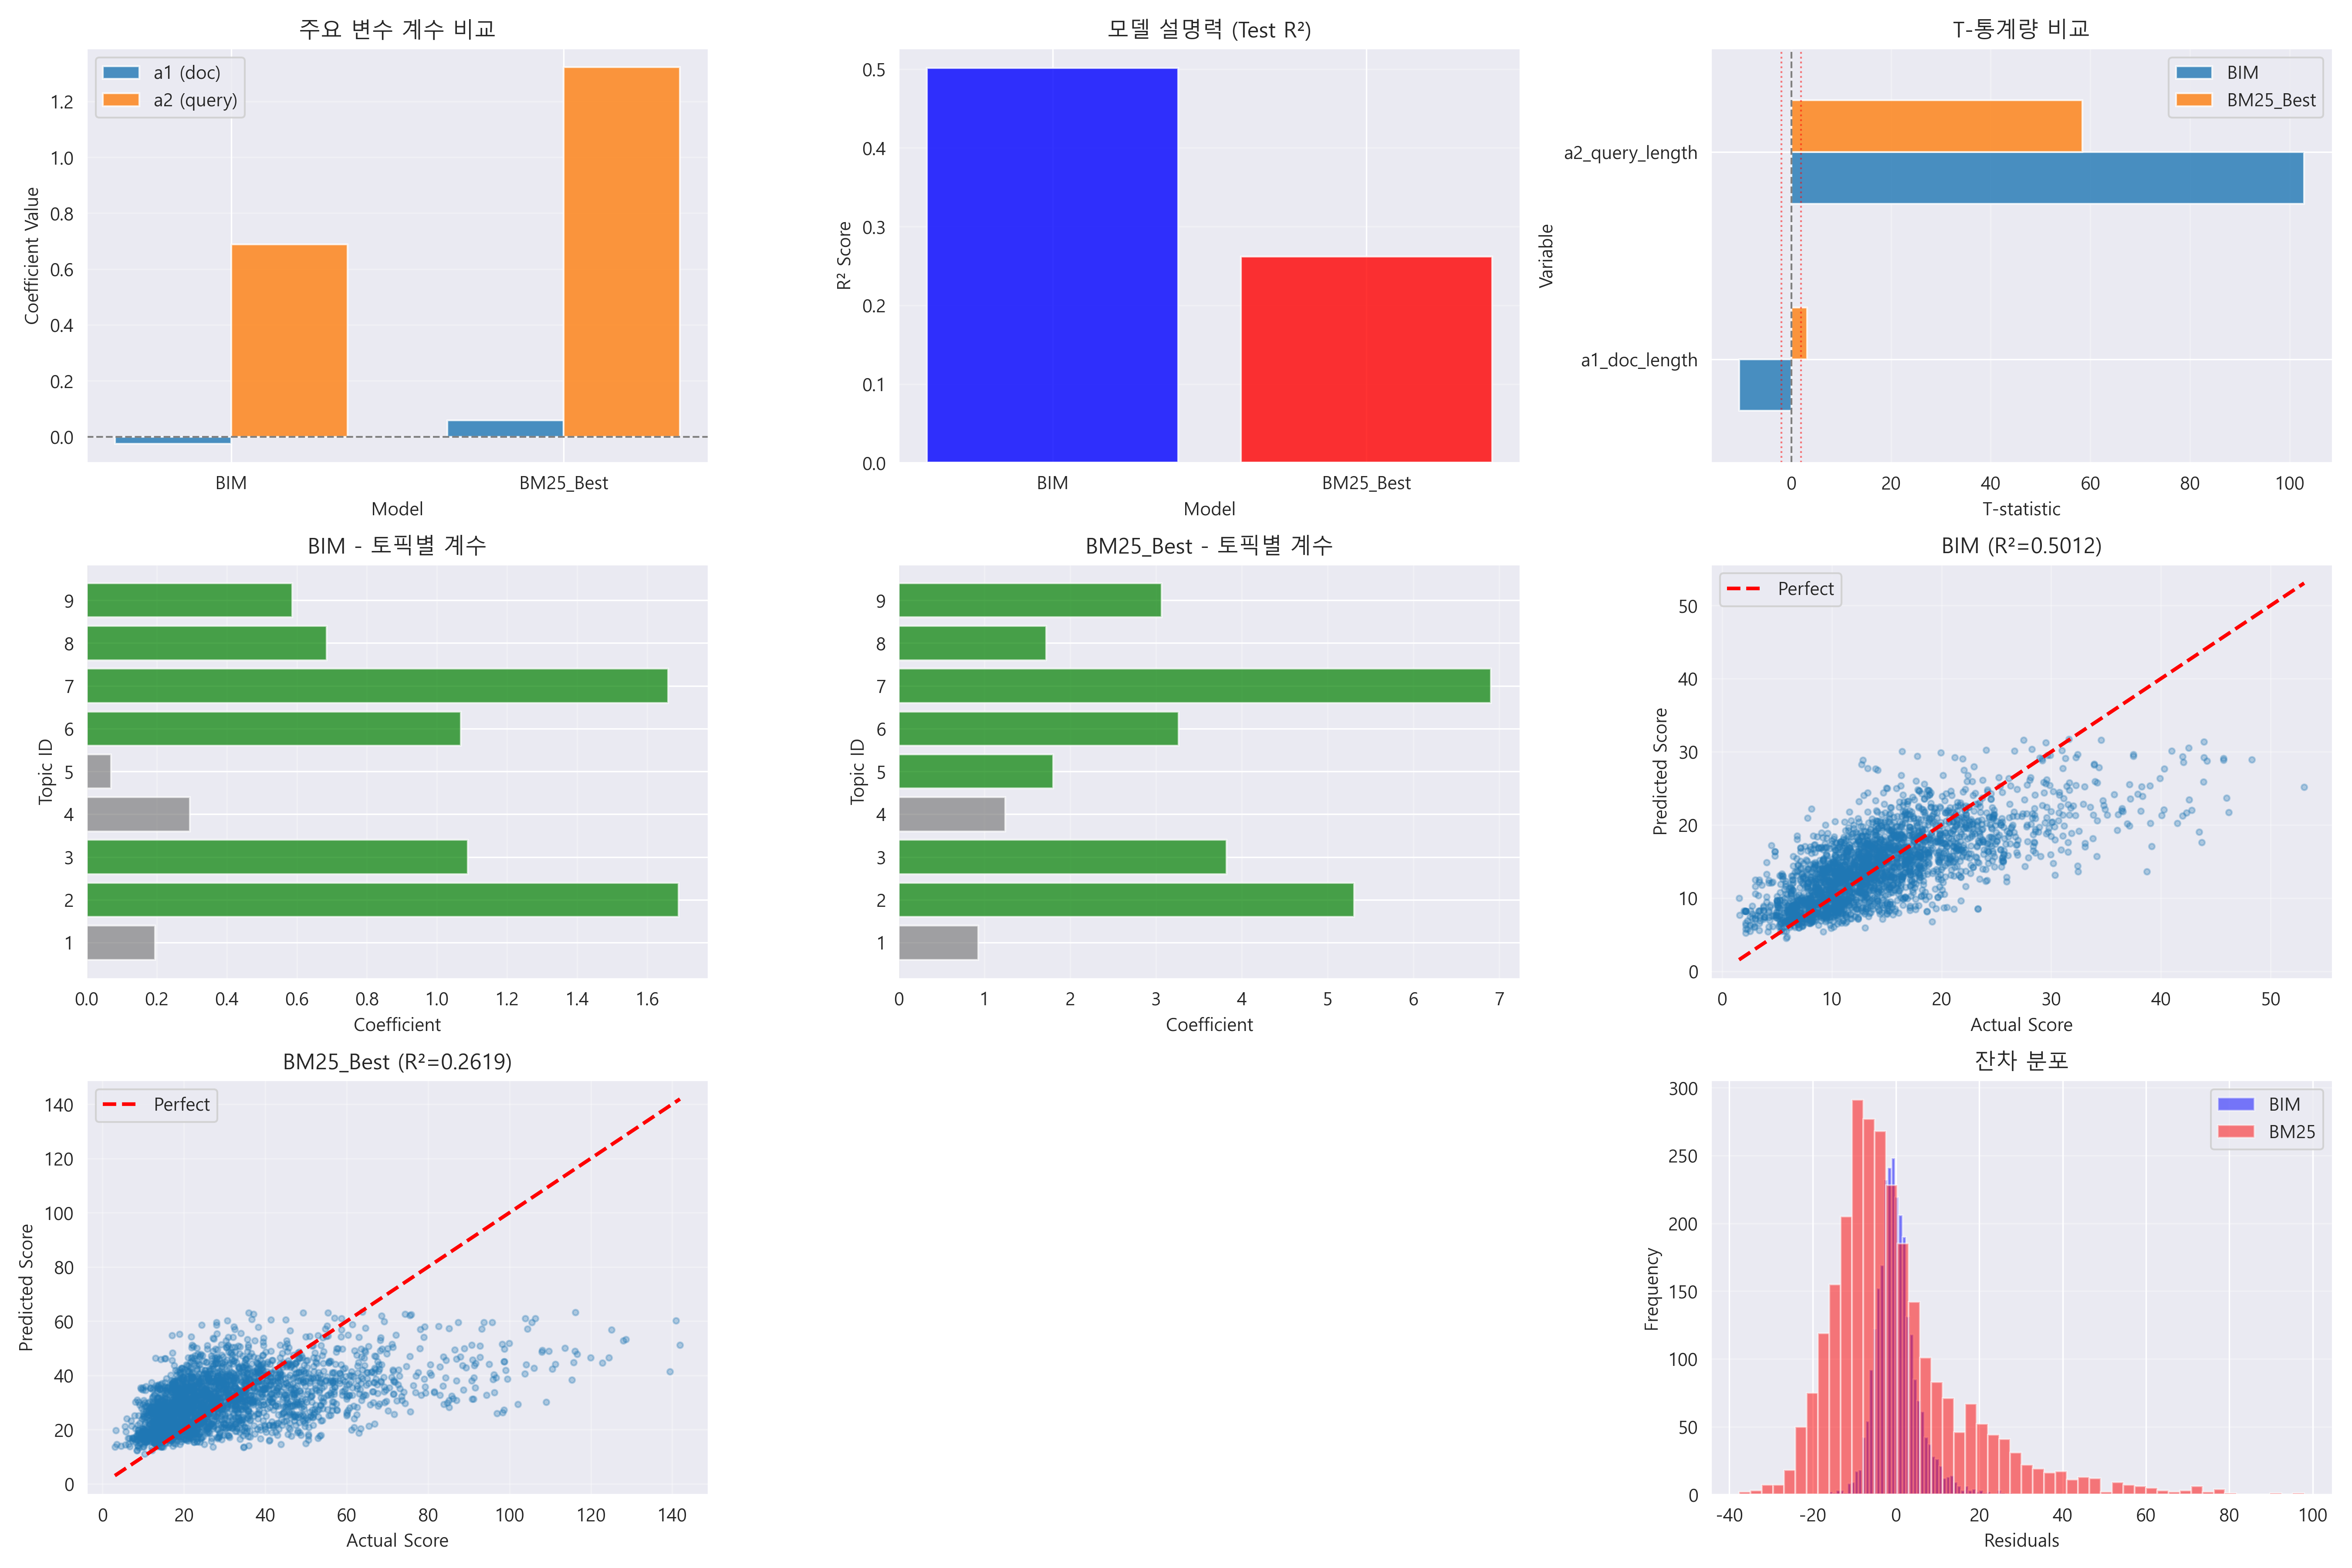

In [62]:
linear_viz_path = os.path.join(DATA_DIR, 'linear_regression_v5.png')
if os.path.exists(linear_viz_path):
    print("[Linear Regression 종합 시각화]")
    display(Image(linear_viz_path))
else:
    print("파일을 찾을 수 없습니다.")

**주요 변수 계수 비교:**
- BIM의 a1(doc)이 음수, BM25는 양수 → 문서 길이에 대한 상반된 태도
- 두 모델 모두 a2(query)가 양수이며 BM25가 더 큼

**모델 설명력:**
- BIM의 Test R²가 BM25보다 약 2배 높음
- 하지만 이는 편향의 증거

**T-통계량 비교:**
- 두 모델 모두 a2(query_length)의 t값이 매우 높음 (100, 60)
- a1(doc_length)은 BIM에서 -10, BM25에서 +3
- 모든 주요 변수가 통계적으로 유의미 (|t| > 1.96)

**토픽별 계수:**
- 초록색: 유의미한 토픽 (p < 0.05)
- 회색: 유의하지 않은 토픽
- BIM: 6개 토픽 유의미, 효과 크기 0.5~1.7
- BM25: 7개 토픽 유의미, 효과 크기 1.7~6.9
- Topic 7(마인크래프트)이 두 모델 모두에서 가장 큰 양의 효과

**Actual vs Predicted:**
- BIM: 점들이 대각선(Perfect) 주변에 밀집, R²=0.50
- BM25: 점들이 더 분산, R²=0.26
- BIM의 높은 설명력은 편향된 예측에서 기인

**잔차 분포:**
- 두 모델 모두 0 근처에 집중된 정규 분포
- BM25의 잔차가 더 넓게 분포 → 예측 불확실성이 높지만, 이는 내용 기반 검색의 자연스러운 특성

---

## 5. 통계적 분석 2: 세부 그룹별 심층 분석 (Sub-group Analysis)

전역 분석에서 확인된 특징이 실제 세부 그룹(Category)에서 어떻게 나타나는지 확인하기 위해 문서 길이, 토픽, 쿼리 복잡도별로 데이터를 분할하여 성능을 평가하였다. 각 그룹에 대해 Multinomial Logistic Regression을 수행하여 그룹별 특성을 분석하였다.


### 5.1 문서 길이별 분석 (Length Analysis)

문서를 형태소 개수 기준으로 3분위(Short, Medium, Long)로 나누어 분석하였다.

#### 길이 카테고리 분포

| Category | Count | Percentage |
|----------|-------|------------|
| Short | 1,669 | 33.4% |
| Medium | 1,664 | 33.3% |
| Long | 1,667 | 33.3% |

#### 길이별 검색 성능 (MAP)

| Category | BIM | BM25 | 차이 |
|----------|-----|------|------|
| Short | 0.646 | 0.740 | +0.094 |
| Medium | 0.640 | 0.757 | +0.117 |
| Long | 0.593 | 0.824 | **+0.231** |

In [63]:
length_perf_path = os.path.join(DATA_DIR, 'length_performance_v3.csv')
if os.path.exists(length_perf_path):
    df_length = pd.read_csv(length_perf_path)
    print("[문서 길이별 성능 요약 (MAP)]")
    display(df_length.pivot_table(index='category', columns='model', values='MAP'))

[문서 길이별 성능 요약 (MAP)]


model,BIM,BM25_Best
category,,
Long,0.592711,0.823939
Medium,0.640311,0.757110
Short,0.645748,0.739834



[길이별 MAP 변화]


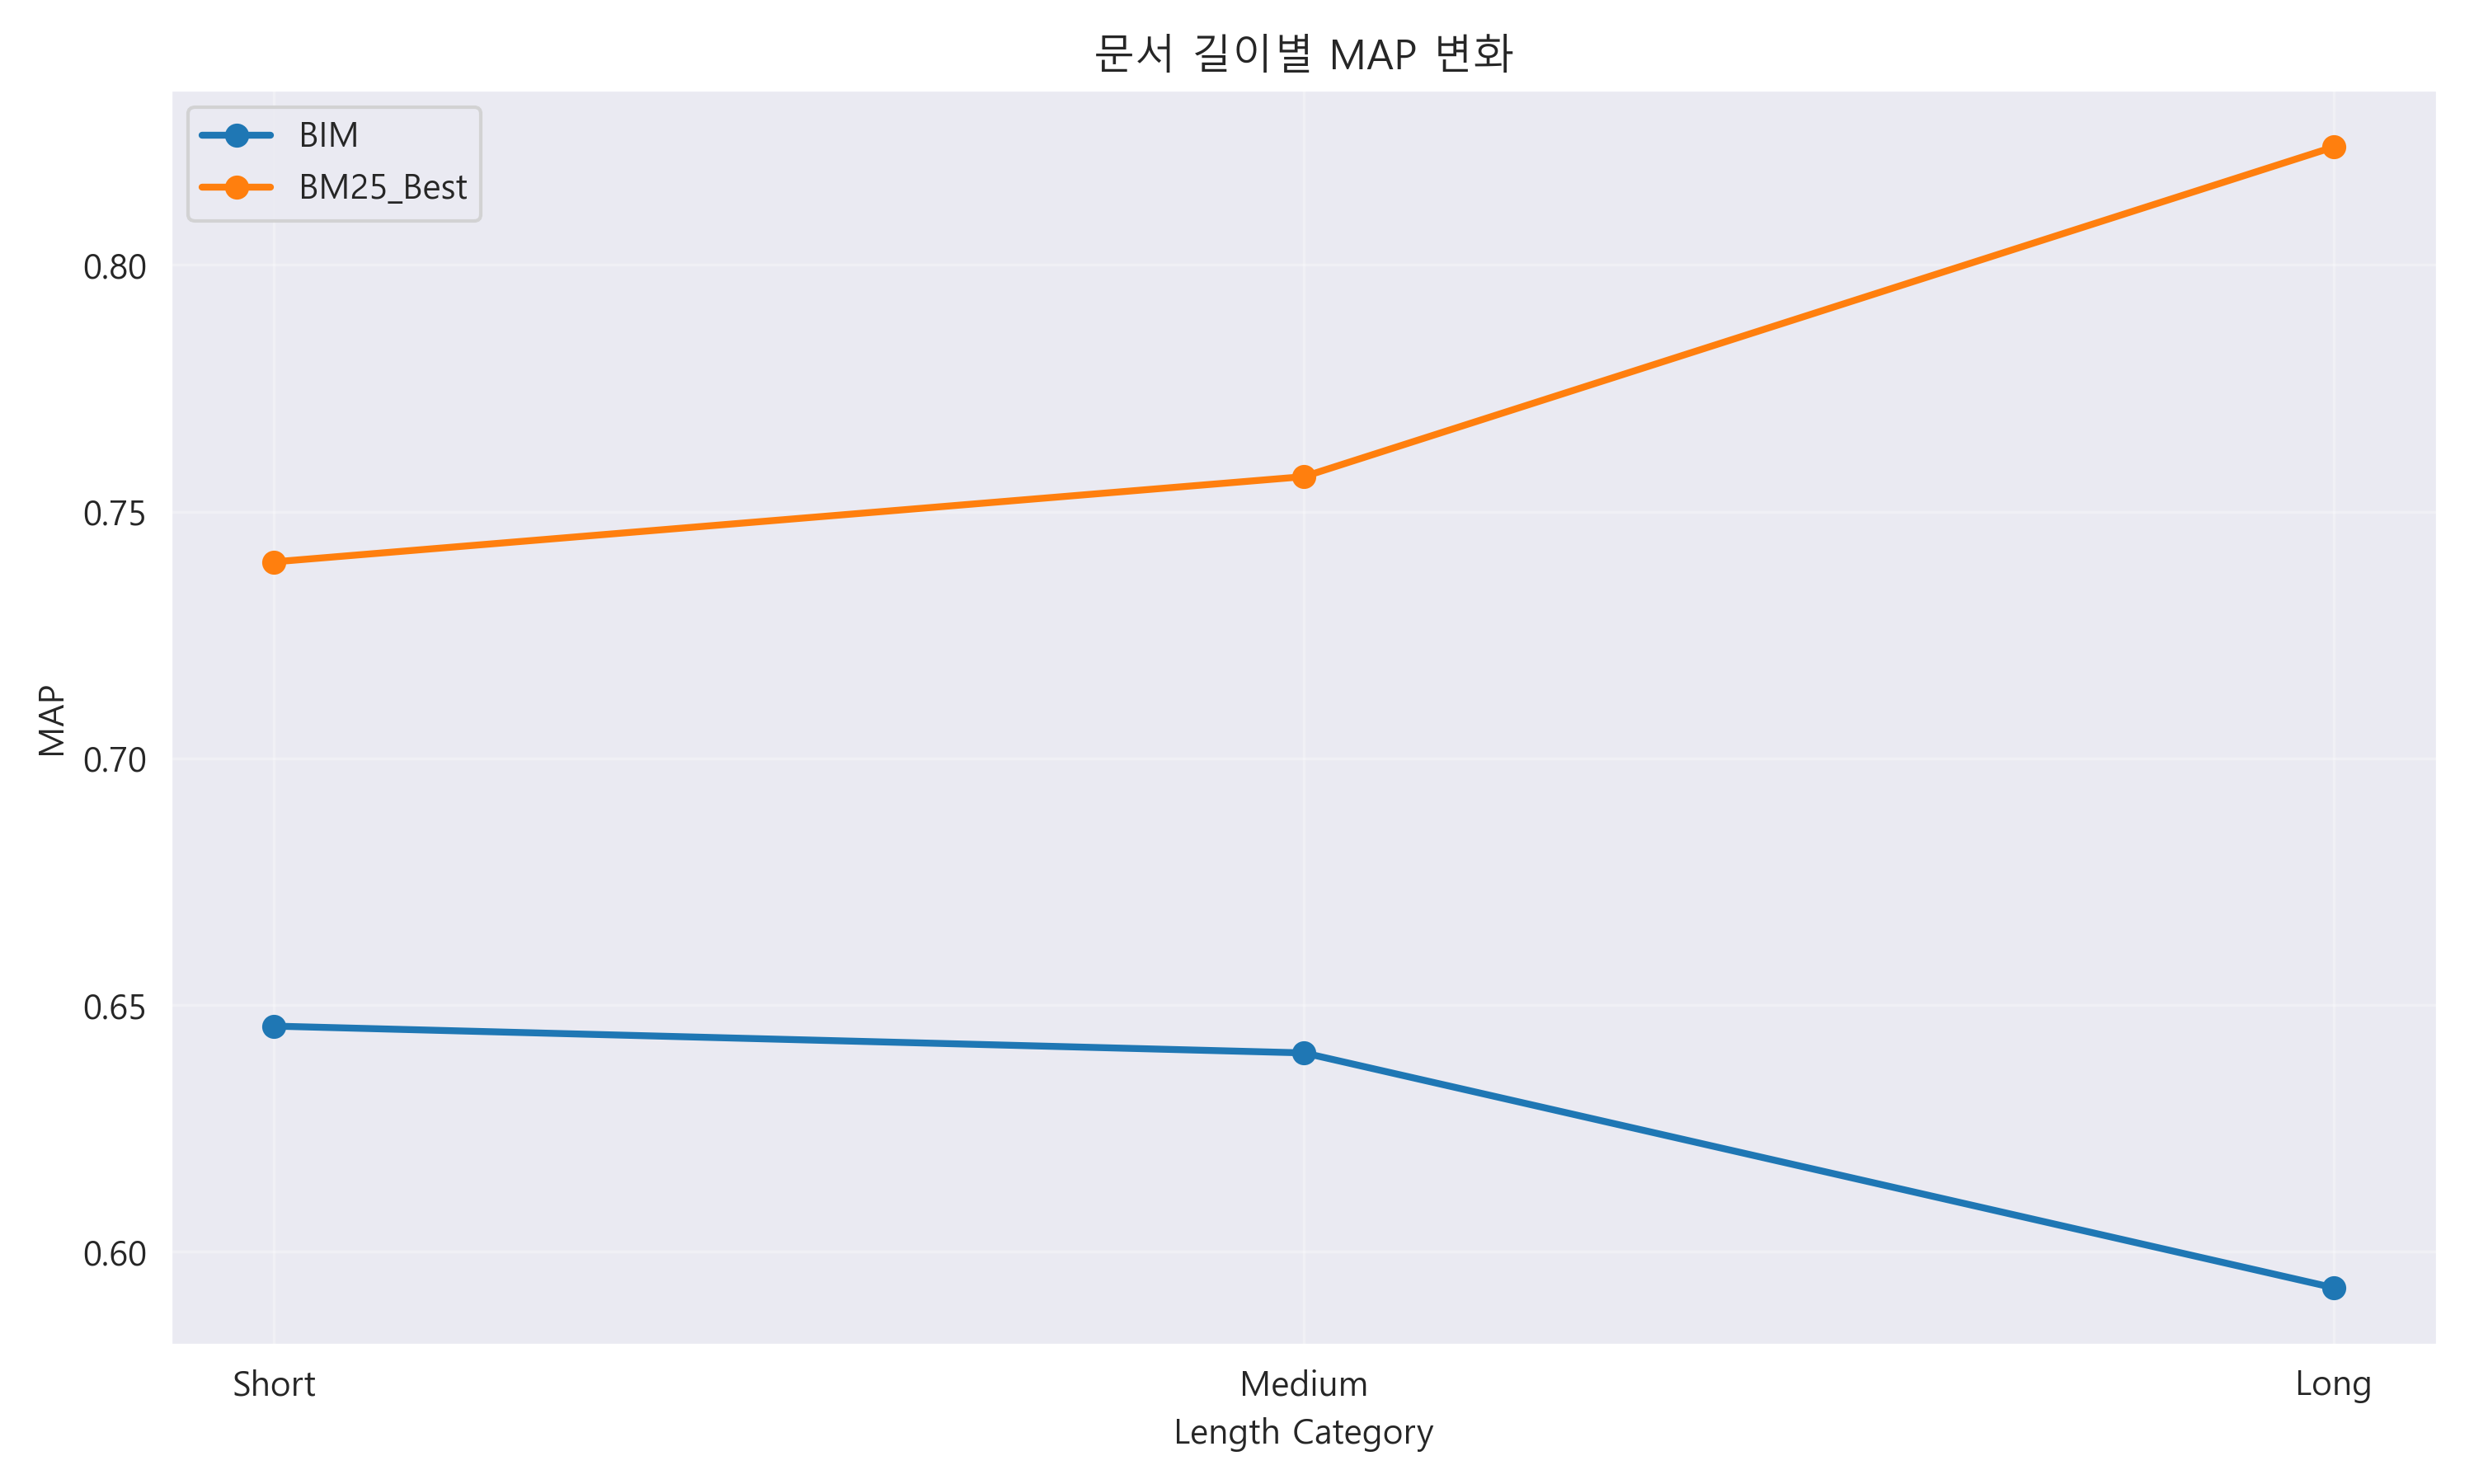

In [64]:
length_map_img = os.path.join(DATA_DIR, 'length_map_trend_v3.png')
if os.path.exists(length_map_img):
    print("\n[길이별 MAP 변화]")
    display(Image(length_map_img))

#### 핵심 발견

1. **Short 문서**: BIM(0.646)과 BM25(0.740)의 차이가 비교적 적다.
- 짧은 문서에서는 길이 정규화의 필요성이 낮음

2. **Long 문서**: BIM 성능은 0.593으로 급락하는 반면, BM25는 0.824로 **최고 성능** 기록
- 성능 차이: +0.231 (39% 개선)
- BIM은 긴 문서를 구조적으로 불리하게 평가
- BM25는 b=0.99 설정으로 긴 문서의 노이즈를 효과적으로 억제하고 정보량의 이점만을 취함

3. **BIM의 성능 저하 패턴**: Short → Medium → Long으로 갈수록 성능이 하락
- 이는 Binary Logistic의 OR=0.89와 일치
- 짧은 문서 편향이 실제 검색 성능에 직접적으로 영향

4. **BM25의 성능 향상 패턴**: Short → Medium → Long으로 갈수록 성능이 **상승**
- Linear Regression의 a1=+0.059와 일치
- 긴 문서의 정보량 이점을 길이 정규화를 통해 공정하게 활용

### 5.2 토픽별 분석 (Topic Analysis)

LDA 토픽별 성능 차이를 통해 모델의 강건성(Robustness)을 확인하였다.

In [65]:
topic_perf_path = os.path.join(DATA_DIR, 'topic_performance_v3.csv')
if os.path.exists(topic_perf_path):
    df_topic = pd.read_csv(topic_perf_path)
    print("[토픽별 성능 요약 (MAP)]")
    display(df_topic.pivot_table(index='topic', columns='model', values='MAP'))

[토픽별 성능 요약 (MAP)]


model,BIM,BM25_Best
topic,,
0,0.536468,0.743077
1,0.541091,0.711131
2,0.330678,0.636476
3,0.600286,0.801964
4,0.568741,0.798081
5,0.533005,0.728361
6,0.617906,0.814300
7,0.561794,0.799971
8,0.500288,0.759863



[토픽별 MAP 변화]


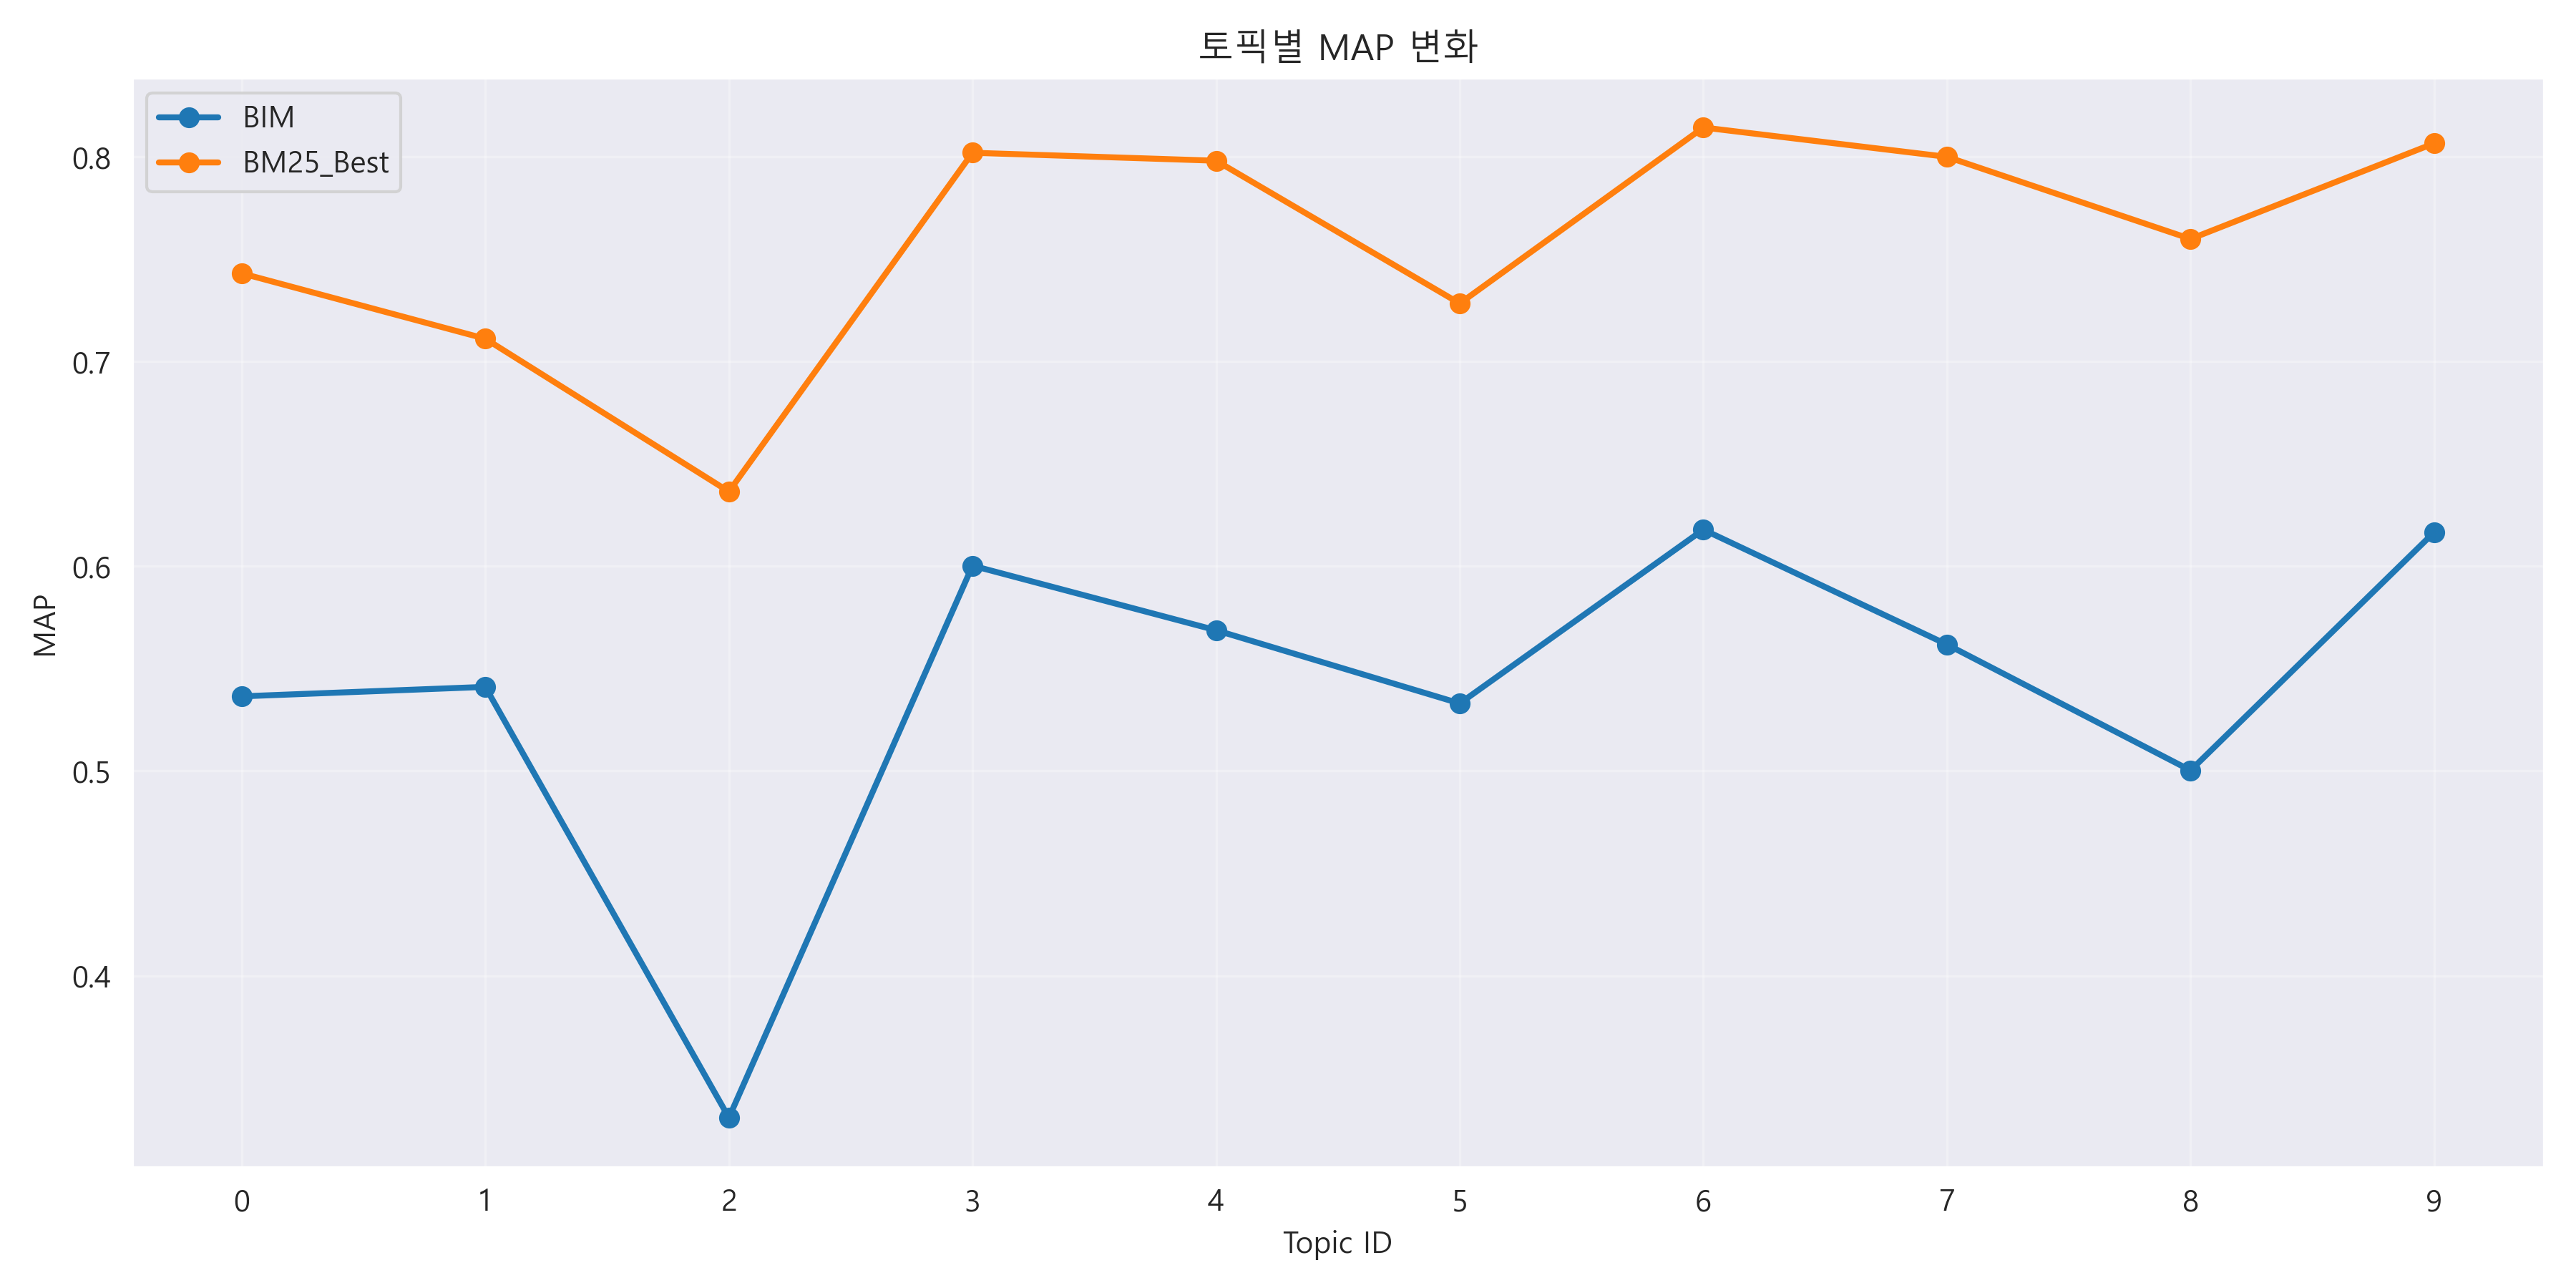

In [66]:
topic_map_img = os.path.join(DATA_DIR, 'topic_map_trend_v3.png')
if os.path.exists(topic_map_img):
    print("\n[토픽별 MAP 변화]")
    display(Image(topic_map_img))


| Topic | BIM | BM25 | 차이 | 토픽 라벨 |
|-------|-----|------|------|----------|
| 0 | 0.536 | 0.743 | +0.207 | 역사/정치 |
| 1 | 0.541 | 0.711 | +0.170 | 일상/감정 |
| **2** | **0.331** | **0.636** | **+0.306** | 스포츠/리그 |
| 3 | 0.600 | 0.802 | +0.202 | 사회/이슈 |
| 4 | 0.569 | 0.798 | +0.229 | 국제/외교 |
| 5 | 0.533 | 0.728 | +0.195 | 게임/RPG |
| 6 | 0.618 | 0.814 | +0.196 | 전쟁/역사 |
| 7 | 0.562 | 0.800 | +0.238 | 마인크래프트(게임) |
| 8 | 0.500 | 0.760 | +0.260 | 방송/연예 |
| 9 | 0.617 | 0.807 | +0.190 | 교통/도시 |


#### 핵심 발견

1. **Topic 2의 낮은 성능**:
- 두 모델 모두 가장 낮은 MAP (BIM: 0.331, BM25: 0.636)
- 스포츠 관련 용어의 어휘적 모호성이 높음 (예: "경기", "선수", "우승" 등은 야구/축구/농구 등에 공통적으로 사용)
- 하지만 BM25는 여전히 0.636으로 BIM보다 2배 높은 성능

2. **Topic 6, 7, 9의 높은 성능**:
- BM25 MAP 0.8 이상
- Topic 6, 7, 9는 고유한 어휘를 가짐
- 키워드 기반 검색에 유리한 도메인

3. **BM25의 일관된 우위**:
- 모든 토픽에서 BM25 > BIM
- 개선폭: 최소 +0.170 (Topic 1) ~ 최대 +0.306 (Topic 2)
- 토픽에 관계없이 BM25의 강건성 확인

4. **Linear Regression 토픽 계수와의 관계**:
- Linear에서 Topic 7 계수가 가장 컸던 것과 달리, 실제 MAP는 Topic 6, 9가 더 높음
- 토픽 계수는 검색 점수에 미치는 영향이지, 절대적 성능이 아님


### 5.3 쿼리 복잡도별 분석 (Complexity Analysis)

쿼리의 길이(형태소 개수)에 따라 Simple/Medium/Complex로 분류하였다.

#### 복잡도 카테고리 분포

| Category | Count | Percentage |
|----------|-------|------------|
| Simple | 1,667 | 33.3% |
| Medium | 1,666 | 33.3% |
| Complex | 1,667 | 33.3% |

#### 복잡도별 검색 성능 (MAP)

In [67]:
complexity_perf_path = os.path.join(DATA_DIR, 'complexity_performance_v3.csv')
if os.path.exists(complexity_perf_path):
    df_complexity = pd.read_csv(complexity_perf_path)
    print("[쿼리 복잡도별 성능 요약 (MAP)]")
    display(df_complexity.pivot_table(index='complexity', columns='model', values='MAP'))

[쿼리 복잡도별 성능 요약 (MAP)]


model,BIM,BM25_Best
complexity,,
Complex,0.513660,0.763999
Medium,0.560490,0.776506
Simple,0.551315,0.743028


| Category | BIM | BM25 | 차이 |
|----------|-----|------|------|
| Simple | 0.551 | 0.743 | +0.192 |
| Medium | 0.560 | 0.777 | +0.217 |
| Complex | 0.514 | 0.764 | **+0.250** |


[복잡도별 MAP 변화]


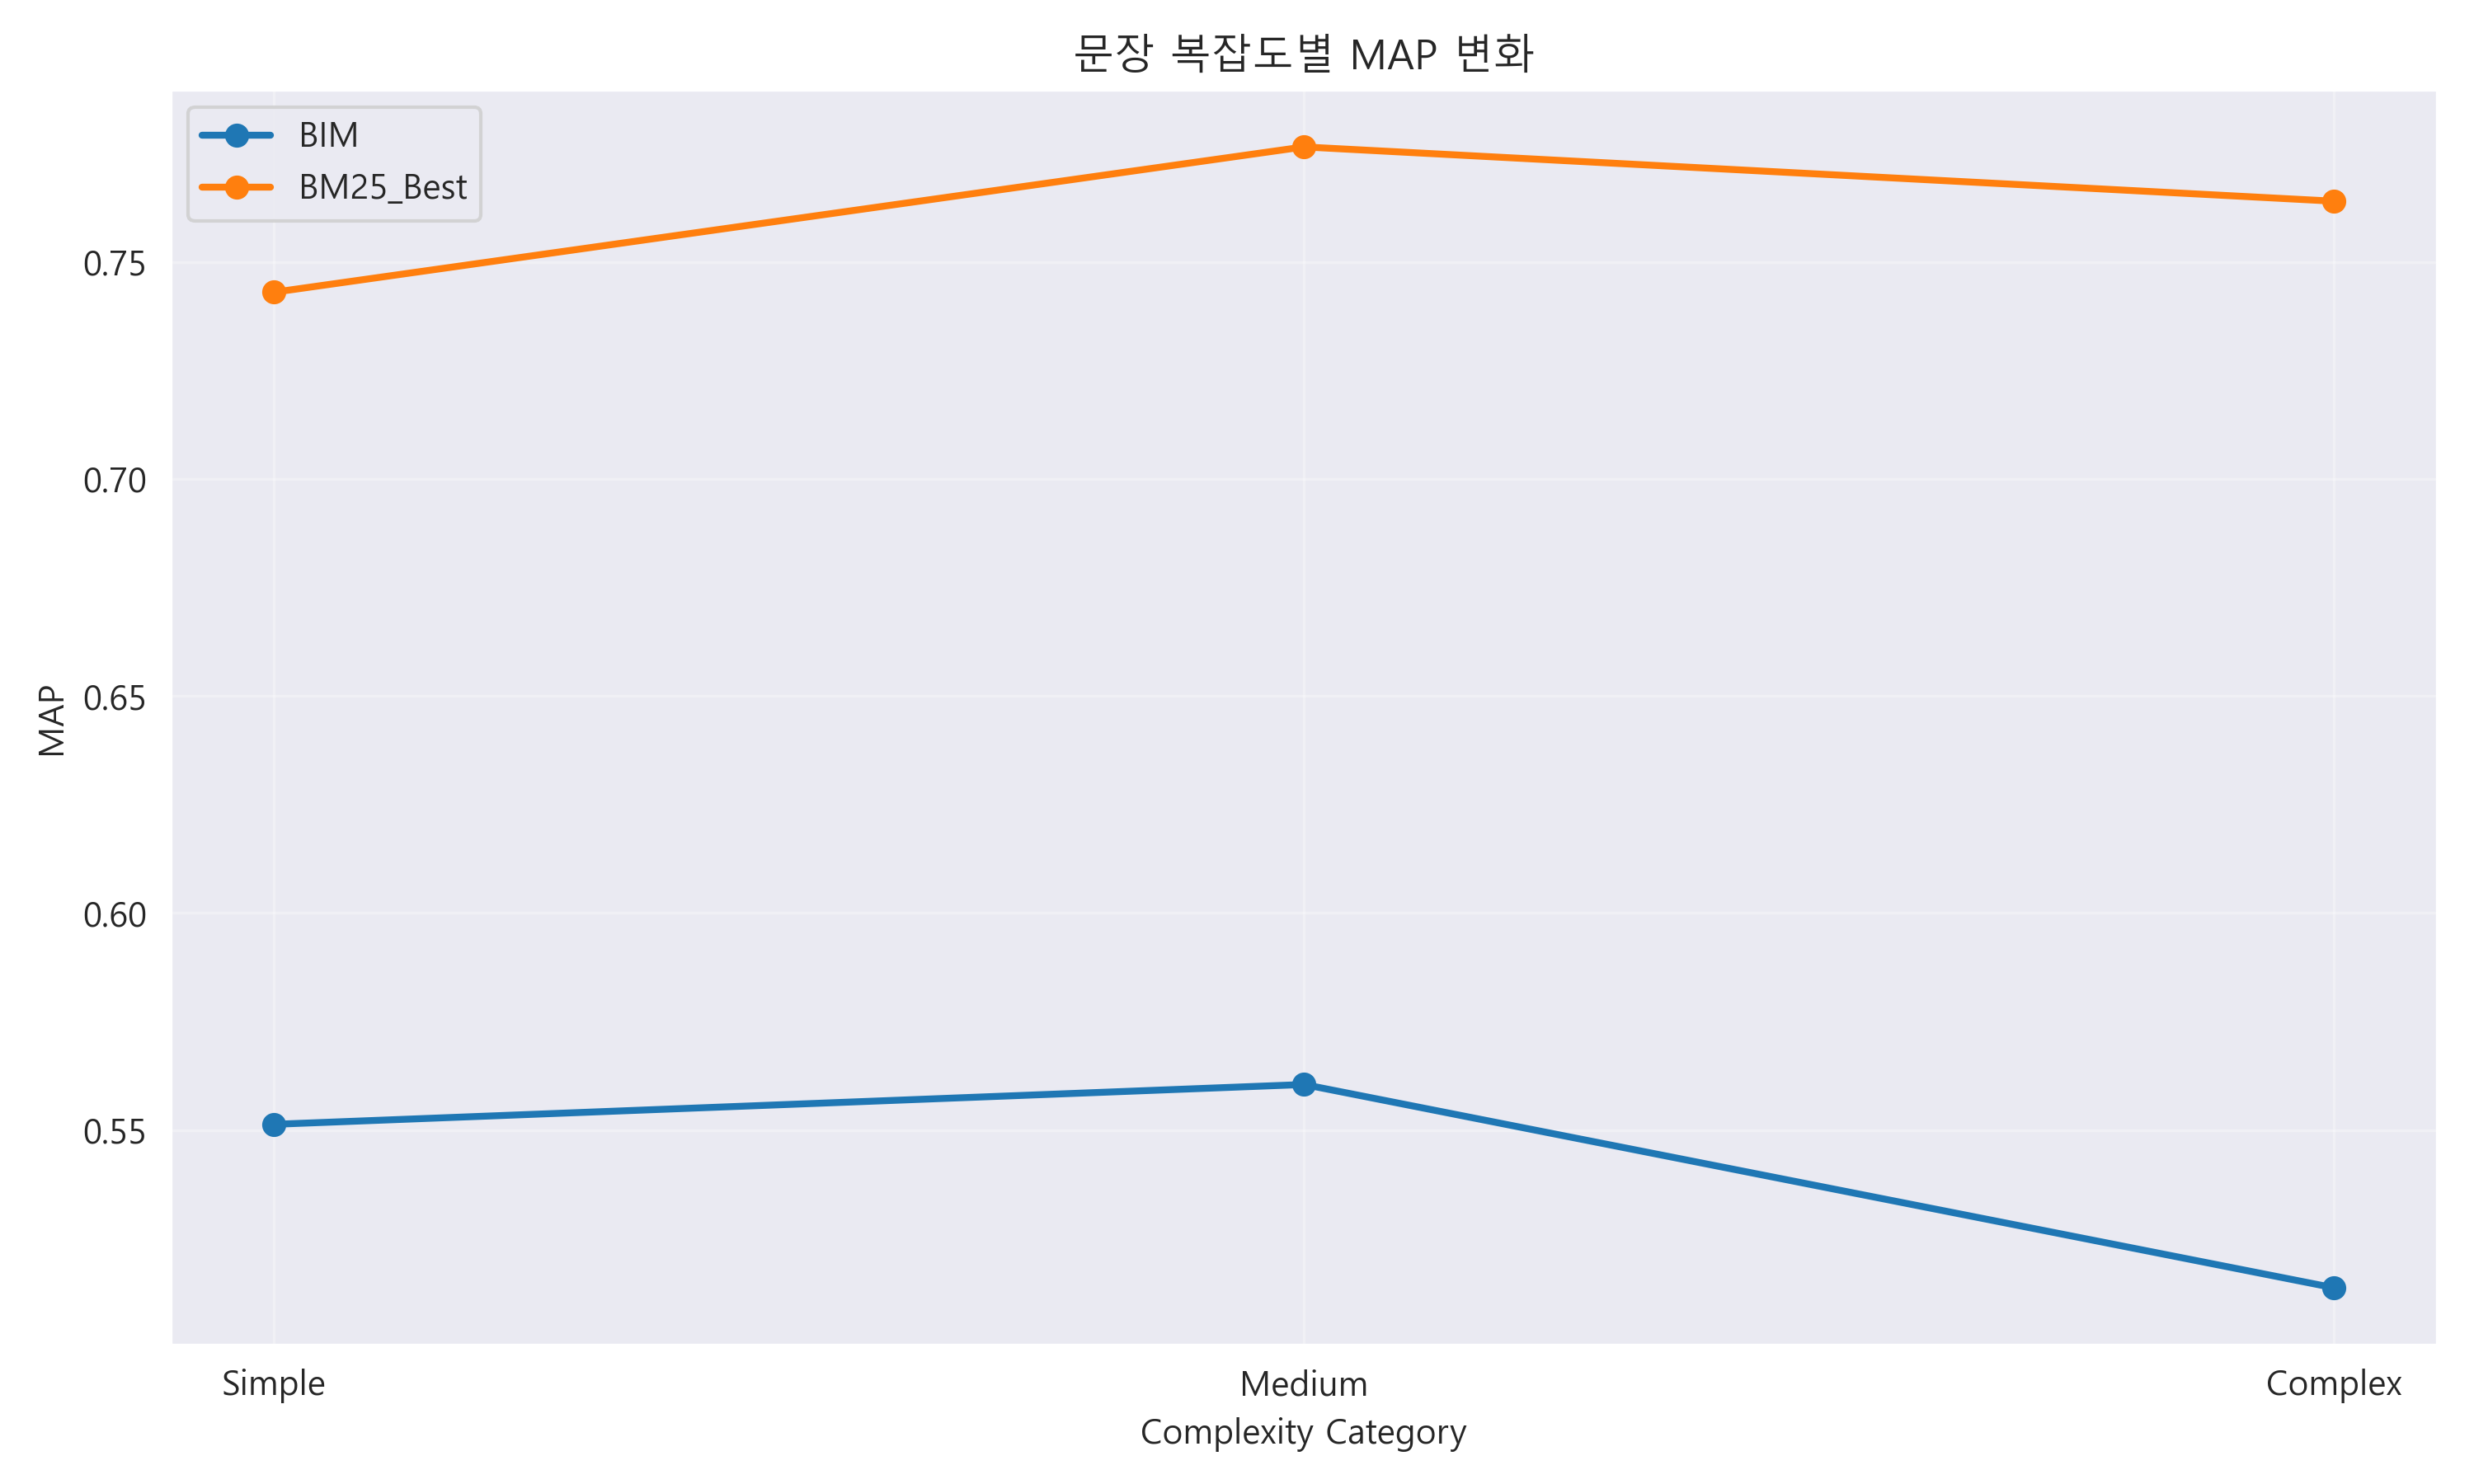

In [68]:
complexity_map_img = os.path.join(DATA_DIR, 'complexity_map_trend_v3.png')
if os.path.exists(complexity_map_img):
    print("\n[복잡도별 MAP 변화]")
    display(Image(complexity_map_img))

#### 핵심 발견

1. **Complex 쿼리에서의 성능 차이**:
- BIM: 0.514로 가장 낮은 성능
- BM25: 0.764로 높은 성능 유지
- 차이: +0.250 (49% 개선)

2. **BIM의 구조적 한계**:
- BIM은 Binary 매칭 방식 (단어의 존재 유무만 확인)
- 쿼리가 길어질수록 모든 키워드를 포함하는 문서를 찾기 어려움
- Complex 쿼리에서 성능 급락

3. **BM25의 유연성**:
- 가중치 합산 방식으로 긴 쿼리의 정보를 유연하게 처리
- Linear Regression의 a2=1.32 (BIM의 0.69보다 높음)와 일치
- 쿼리 길이 증가에 더 효과적으로 대응

4. **실무적 시사점**:
- 사용자의 질의가 구체적이고 길수록 BM25가 더 유리
- 나무위키 검색 시나리오: "형님들, 조선이 청나라 속국이 되었다는 건..." 같은 긴 질의가 빈번
- BM25가 이러한 사용자 행동에 더 적합

### 5.4 종합 시각화

[세부 분석 종합 시각화]


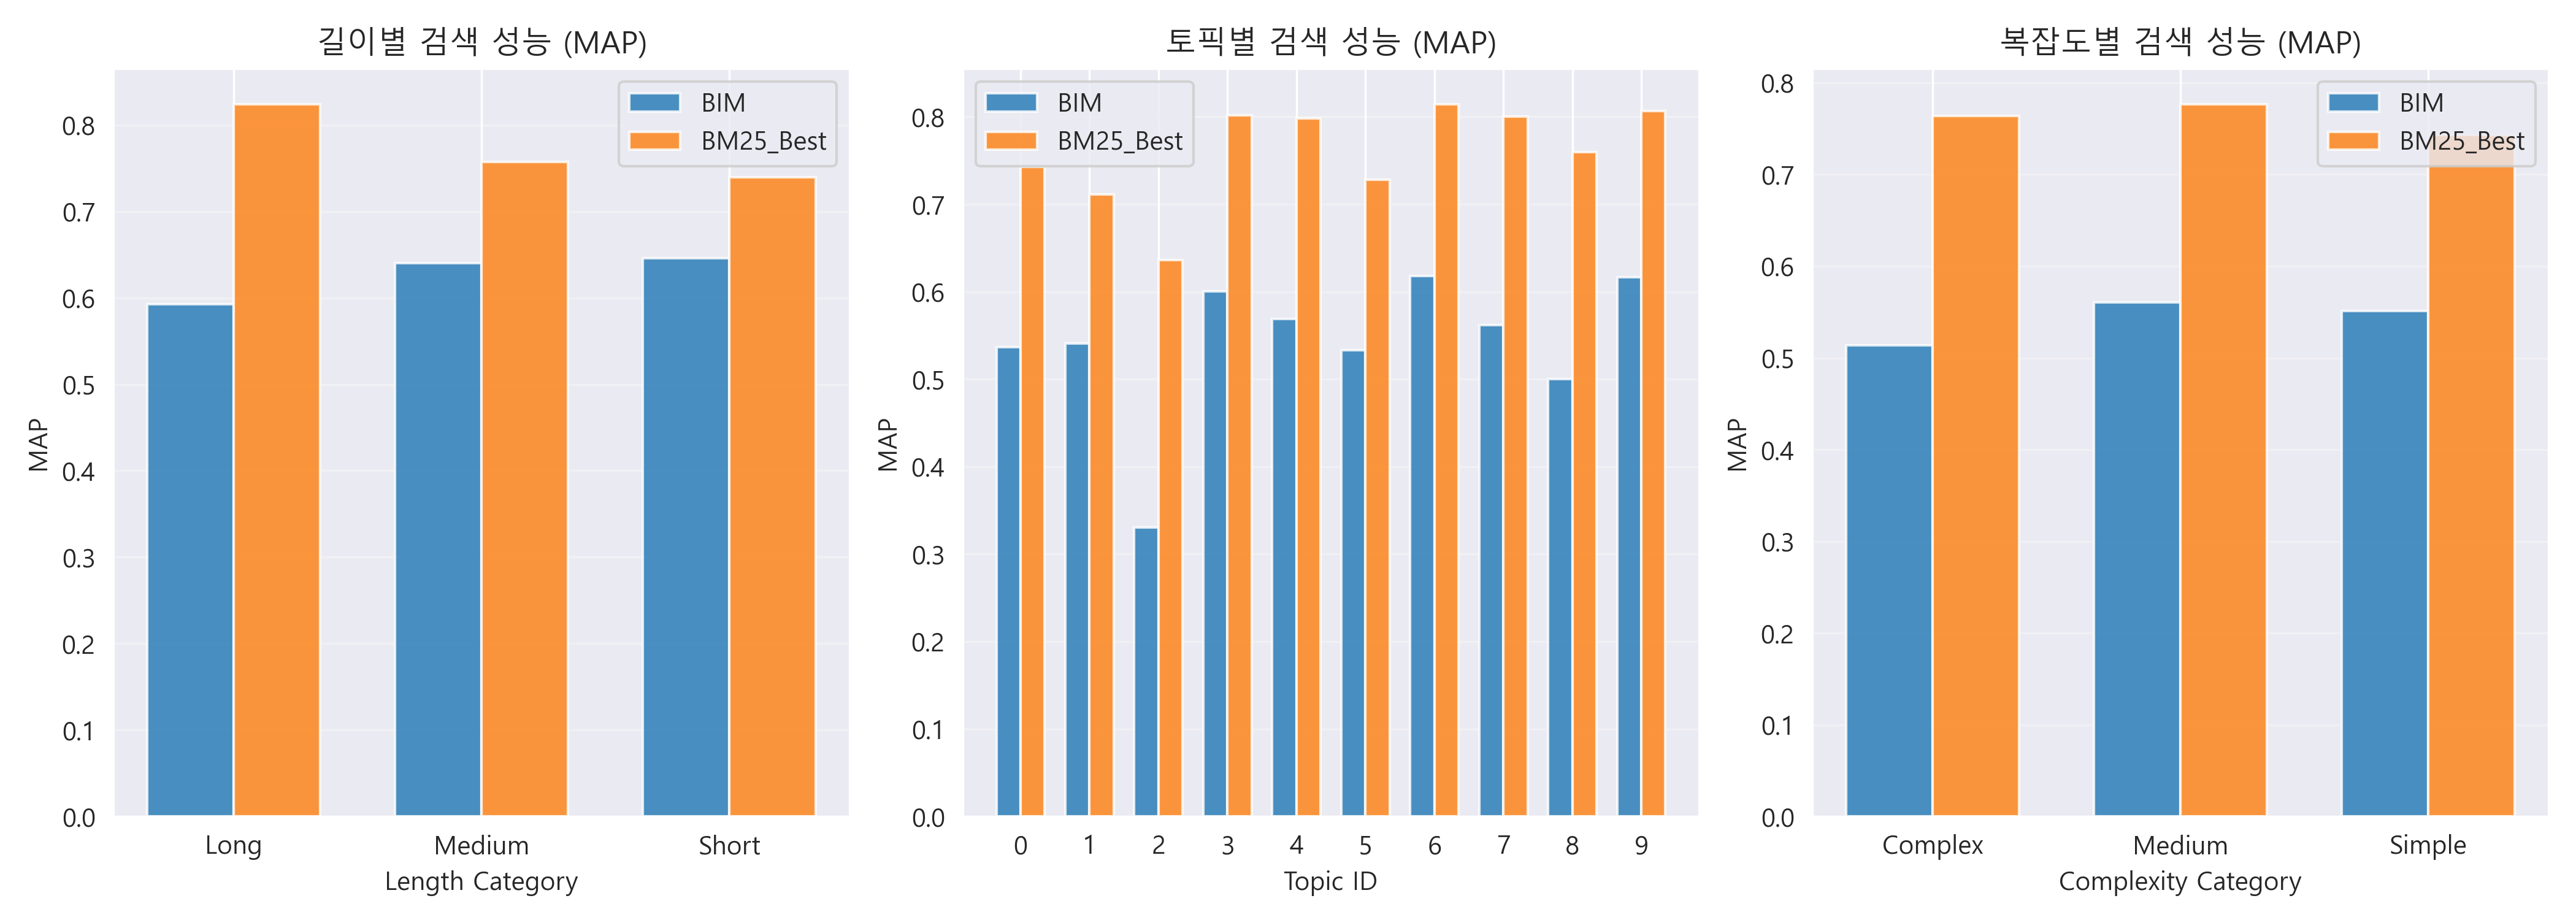

In [69]:
additional_img = os.path.join(DATA_DIR, 'additional_analysis_v3.png')
if os.path.exists(additional_img):
    print("[세부 분석 종합 시각화]")
    display(Image(additional_img))

**길이별, 토픽별, 복잡도별 검색 성능을 한눈에 비교:**

- 모든 카테고리에서 BM25 > BIM
- Long 문서, Complex 쿼리에서 차이가 극대화
- 토픽별로는 Topic 2가 가장 어려운 도메인

---

## 6. 도메인/토픽 변수 심층 분석

Linear Regression에서는 토픽이 유의미한 영향을 보였으나, Binary Logistic과 가중치 튜닝에서는 w3=0.0으로 수렴하였다. 이 모순을 해결하기 위해 실제 검색 케이스 10개를 정성적으로 분석하였다.

### 6.1 분석 방법

1. 유효한 쿼리 중 무작위 10개 추출
2. BM25 (k1=3.25, b=0.99) 검색 결과 분석
3. 정답 문서와 오답 문서의 토픽 분포 비교
4. 패턴 분류 및 해석

In [76]:
!pip install kiwipiepy datasets tqdm pandas numpy matplotlib seaborn scikit-learn

In [75]:
import os
import pickle
import random
import math
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import sqlite3

BASE_DIR = os.path.join('..')
DATA_DIR = os.path.join(BASE_DIR, 'data_final')
DB_DIR = os.path.join(BASE_DIR, 'database_final')

DATA_PATH = os.path.join(DATA_DIR, 'sampled_data_v2.pkl')
DB_PATH = os.path.join(DB_DIR, 'search_index_v2.db')

QUERIES_PATH = os.path.join(BASE_DIR, 'data', 'queries.pkl')
QRELS_PATH = os.path.join(BASE_DIR, 'data', 'qrels.pkl')

df = pd.read_pickle(DATA_PATH)

if '_id' in df.columns:
    df.set_index('_id', inplace=True)
elif 'doc_id' in df.columns:
    df.set_index('doc_id', inplace=True)
df.index = df.index.astype(str)

with open(QUERIES_PATH, 'rb') as f:
    queries_data = pickle.load(f)
with open(QRELS_PATH, 'rb') as f:
    qrels_data = pickle.load(f)

qrels_dict = {}
for item in qrels_data:
    qid, doc_id = str(item.get('query-id')), str(item.get('corpus-id'))
    if qid and doc_id:
        qrels_dict.setdefault(qid, set()).add(doc_id)

queries_map = {str(q['_id']): q['text'] for q in queries_data if '_id' in q}

kiwi = Kiwi(num_workers=-1)

def tokenize_query(text):
    try:
        return [t.form for t in kiwi.tokenize(text) if t.tag in ['NNG', 'NNP', 'VV', 'VA', 'MAG']]
    except:
        return []

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

total_docs = len(df)
avg_dl = df['doc_length'].mean()

def get_term_idf(term):
    cursor.execute('SELECT COUNT(DISTINCT doc_id) FROM inverted_index WHERE term=?', (term,))
    df_val = cursor.fetchone()[0]
    return math.log((total_docs - df_val + 0.5) / (df_val + 0.5) + 1) if df_val > 0 else 0

def calculate_scores(query_tokens, k1=5.5, b=0.99):
    scores = {}
    for term in query_tokens:
        idf = get_term_idf(term)
        if idf <= 0: continue

        cursor.execute('SELECT doc_id, tf FROM inverted_index WHERE term = ?', (term,))
        rows = cursor.fetchall()

        for doc_id, tf in rows:
            if doc_id not in df.index: continue

            doc_len = df.at[doc_id, 'doc_length']
            num = tf * (k1 + 1)
            den = tf + k1 * (1 - b + b * (doc_len / avg_dl))
            scores[doc_id] = scores.get(doc_id, 0.0) + idf * (num / den)
    return scores

valid_qids = []
for qid, docs in qrels_dict.items():
    if qid in queries_map and any(d in df.index for d in docs):
        valid_qids.append(qid)

if not valid_qids:
    print("오류: 유효한 쿼리를 찾을 수 없습니다.")
else:
    num_samples = min(10, len(valid_qids))
    test_qids = random.sample(valid_qids, num_samples)

    print(f"총 {num_samples}개의 쿼리에 대해 진단\n")

    for idx, test_qid in enumerate(test_qids):
        print("-" * 80)
        print(f"[CASE {idx + 1} / {num_samples}]")

        query_text = queries_map[test_qid]
        q_tokens = tokenize_query(query_text)
        target_docs = qrels_dict.get(test_qid, set())
        valid_targets = [d for d in target_docs if d in df.index]

        print(f"ID: {test_qid}")
        print(f"내용: {query_text}")
        print(f"토큰: {q_tokens}")
        print(f"정답 문서: {len(target_docs)}개 (샘플 내: {len(valid_targets)}개)")

        scores = calculate_scores(q_tokens, k1=5.5, b=0.99)
        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        top_10 = ranked[:10]

        print("\n1. 상위 검색 결과 (Top 10)")
        print(f"{'순위':<4} {'점수':<8} {'문서ID':<15} {'토픽':<6} {'확률':<6} {'정답':<4} {'미리보기'}")

        ranked_ids = [d for d, s in ranked]

        for i, (doc_id, score) in enumerate(top_10):
            is_hit = "O" if doc_id in target_docs else "X"
            doc_topic = np.argmax(df.at[doc_id, 'topic_probs'])
            doc_prob = df.at[doc_id, 'topic_probs'][doc_topic]
            full_text = df.at[doc_id, 'text']
            title = df.at[doc_id, 'title'] if 'title' in df.columns else full_text[:20]
            preview = str(title).replace('\n', ' ')[:25]

            print(f"{i+1:<4} {score:<8.2f} {doc_id:<15} {doc_topic:<6} {doc_prob:<6.2f} {is_hit:<4} {preview}")

        print("\n2. 정답 문서 분석 (Ground Truth)")
        print(f"{'문서ID':<15} {'토픽':<6} {'확률':<6} {'검색순위'}")

        rel_topics = []
        for doc_id in list(valid_targets)[:5]:
            doc_topic = np.argmax(df.at[doc_id, 'topic_probs'])
            doc_prob = df.at[doc_id, 'topic_probs'][doc_topic]
            rel_topics.append(doc_topic)

            try:
                rank = ranked_ids.index(doc_id) + 1
            except ValueError:
                rank = "순위밖"

            print(f"{doc_id:<15} {doc_topic:<6} {doc_prob:<6.2f} {rank}")

        print("\n3. 진단 및 해석")
        unique_topics = set(rel_topics)
        if len(unique_topics) > 1:
            print(f"- 토픽 불일치: 정답 문서들이 서로 다른 토픽 {unique_topics}을 가짐.")
            print("  → 해석: 정답 간 공통된 토픽이 없으므로, 토픽 가중치가 0이 됨.")
        elif len(unique_topics) == 1:
            print(f"- 토픽 일치: 정답 문서들이 동일한 토픽 {unique_topics}을 가짐.")
            print("  → 해석: 그럼에도 오답 문서들과의 변별력이 없다면 토픽 정보는 무용지물")

        found_count = sum(1 for d in valid_targets if d in ranked_ids[:10])
        if found_count > 0:
            print(f"- 검색 성능: 정답 {len(valid_targets)}개 중 {found_count}개가 Top 10에 포함됨. (BM25 유효)")
        else:
            print(f"- 검색 성능: Top 10에 정답 없음. (키워드 불일치 또는 어휘 불일치 가능성)")

        print("\n")

conn.close()

총 10개의 쿼리에 대해 진단

--------------------------------------------------------------------------------
[CASE 1 / 10]
ID: query_001403
내용: 얘들아, 브롤스타즈 젬 그랩에서 없어졌다가 다시 생긴 그 돌 광산 맵 이름 뭐였지? 복귀한 거 맞나요?
토큰: ['브롤스타즈', '랩', '없', '다시', '생기', '돌', '광산', '이름', '복귀', '맞']
정답 문서: 6개 (샘플 내: 5개)

1. 상위 검색 결과 (Top 10)
순위    점수        문서ID             토픽      확률      정답    미리보기
1     85.67      브롤스타즈/맵/흔들 광산   7       0.35     O      브롤스타즈/맵/흔들 광산
2     73.61      브롤스타즈/맵/암석 광산   2       0.63     O      브롤스타즈/맵/암석 광산
3     73.29      브롤스타즈/맵/수정 오락실  2       0.56     O      브롤스타즈/맵/수정 오락실
4     66.42      브롤스타즈/맵/선인장 함정  2       0.53     O      브롤스타즈/맵/선인장 함정
5     32.14      플래티나워매몬           2       0.44     X      플래티나워매몬
6     29.92      캐피탈리즘 랩            7       0.48     X      캐피탈리즘 랩
7     28.82      가라르광산              7       0.58     X      가라르광산
8     26.72      플래시 도타/맵          2       0.36     O      플래시 도타/맵
9     26.60      멘마(나루토)            3       0.86     X      멘마(나루토)
10    24.82      카

### 6.2 대표 케이스 분석

#### CASE 1: 브롤스타즈 맵 (토픽 불일치)

**쿼리**: "브롤스타즈 젬 그랩에서 없어졌다가 다시 생긴 그 돌 광산 맵 이름 뭐였지?"

**정답 문서 (5개):**
- 브롤스타즈/맵/흔들 광산 (Topic 7)
- 브롤스타즈/맵/암석 광산 (Topic 2) ☑
- 브롤스타즈/맵/수정 오락실 (Topic 2) ☑
- 브롤스타즈/맵/선인장 함정 (Topic 2) ☑
- 플래시 도타/맵 (Topic 2) ☑

**진단:**
- 정답 문서들이 Topic 2와 Topic 7로 **분산**
- 특정 토픽에 가중치를 주면 다른 토픽의 정답이 순위 밖으로 밀림
- **토픽 가중치 0이 최선**

#### CASE 3: 병자호란 (토픽 변별력 부재)

**쿼리**: "조선이 청나라 속국이 되었다는 건 알겠는데 병자호란 때문인가요? 삼전도에서..."

**Top 10 검색 결과:**

| 순위 | 문서 | 토픽 | 정답 |
|-----|------|------|------|
| 1 | 삼전도의 굴욕 | 0 | ☑ |
| 2 | 김상헌(조선) | 0 | ☑ |
| 3 | 삼전도비 | 0 | ☑ |
| 4 | 한국-만주 관계 | 0 | ☑ |
| ... | ... | 0 | ... |
| 9 | 북한-만주 관계 | 0 | ✖ |

**진단:**
- 정답('삼전도의 굴욕')과 오답('북한-만주 관계')가 **동일한 Topic 0**
- 토픽 가중치를 높여도 오답이 함께 상위로 올라옴
- **토픽 정보는 변별력 없음**

#### CASE 10: 스쿨 오브 락 (토픽 일치하지만 무용)

**쿼리**: "2003년 잭 블랙이 출연한 코미디 영화... 록 밴드를 결성하는..."

**Top 10 검색 결과:**

| 순위 | 문서 | 토픽 | 정답 |
|-----|------|------|------|
| 1 | 스쿨 오브 락 | 5 | ☑ |
| 2 | 잭 블랙 | 5 | ☑ |
| 3 | 잭 앤 질 | 3 | ✖ |
| 4 | YB (밴드) | 5 | ✖ |
| 5 | 로버트 패트릭 | 3 | ✖ |
| 6 | 장준환 | 5 | ✖ |

**진단:**
- 정답(영화)과 오답(가수)이 모두 Topic 5 (게임/엔터테인먼트)
- 토픽만으로는 영화와 가수를 구별할 수 없음
- **토픽의 거시적 분류는 세밀한 구별에 부적합**

### 6.3 패턴 분석

10개 케이스를 분석한 결과, 두 가지 주요 패턴을 발견하였다.

#### 패턴 A: 토픽 변별력 부재 (8개 케이스)

**현상**: 정답 문서들이 동일한 토픽에 속하지만, 오답 문서들도 같은 토픽

**예시:**
- CASE 3 (병자호란): 정답('삼전도'), 오답('북한-만주') 모두 Topic 0
- CASE 10 (스쿨 오브 락): 정답(영화), 오답(가수) 모두 Topic 5

**결론**: 토픽 가중치를 높이면 주제만 같고 내용은 다른 오답이 상위로 난입

#### 패턴 B: 토픽 불일치 (2개 케이스)

**현상**: 정답 문서들이 서로 다른 토픽으로 분류됨

**예시:**
- CASE 1 (브롤스타즈): 정답이 Topic 2, 7로 분산
- CASE 7 (세리스): 정답이 Topic 2, 3, 9로 분산

**결론**: 특정 토픽에 가중치를 주면 다른 토픽의 정답 문서들이 순위 밖으로 밀려남

### 6.4 종합 결론

**w3 (토픽 가중치) = 0.0인 이유:**

1. **변별력 부재**: 토픽은 정답과 오답을 구별하지 못함 (패턴 A)
2. **키워드의 압도적 우위**: 10개 케이스 대부분에서 BM25만으로 정답을 1~3위에 정확히 배치
3. **방해 요소**: 토픽 정보는 오히려 검색 품질을 저하시킬 가능성이 큼 (패턴 B)

**Linear Regression에서 토픽이 유의미했던 이유:**

- Linear는 검색 **점수 자체**를 예측
- Topic 7 (마인크래프트)는 특정 어휘가 많아 검색 점수가 높아지는 경향
- 하지만 이것이 **관련성(0/1) 판단**에는 도움이 되지 않음

**최종 결론:**

LDA 토픽은 문서를 거시적 주제로 분류할 뿐, 사용자의 구체적 질문 의도를 파악하지 못한다. 따라서 검색 랭킹에서 토픽 정보를 배제하는 것이 올바른 선택이 맞다.

---

## 7. 결론

### 7.1 연구 결과 요약

본 연구는 BIM과 BM25 모델을 한국어 나무위키 데이터셋에 적용하여 세 가지 회귀 분석 방법론을 통해 체계적으로 비교하였다.

#### 검색 성능 최종 비교

In [70]:
print("[검색 성능 최종 비교]")
perf_data = {
    '평가 지표': ['MAP', 'P@10', 'R@10', 'MAP 표준편차', 'P@10 표준편차', 'R@10 표준편차'],
    'BIM': [0.416, 0.193, 0.520, 0.343, 0.189, 0.376],
    'BM25': [0.631, 0.270, 0.681, 0.325, 0.224, 0.314],
    '개선율': ['+51.5%', '+40.0%', '+31.0%', '-5.3%', '+18.5%', '-16.5%']
}
df_perf = pd.DataFrame(perf_data)
display(df_perf)

[검색 성능 최종 비교]


,평가 지표,BIM,BM25,개선율
0,MAP,0.416,0.631,+51.5%
1,P@10,0.193,0.270,+40.0%
2,R@10,0.520,0.681,+31.0%
3,MAP 표준편차,0.343,0.325,-5.3%
4,P@10 표준편차,0.189,0.224,+18.5%
5,R@10 표준편차,0.376,0.314,-16.5%


#### 회귀 분석 결과 종합

**1. Binary Logistic Regression (Odds Ratio):**

| 변수 | BIM OR | BM25 OR | 해석 |
|------|--------|---------|------|
| a1: doc_length | 0.8949 *** | 1.0086 *** | BIM: 짧은 문서 편향 |
| a2: query_length | 1.0690 *** | 1.0329 *** | 둘 다 긍정적 |
| a3: dominant_topic | 1.09~1.66 | 0.95~1.50 | 변별력 없음 |

- Pseudo R²: BIM 0.234 vs BM25 0.016 → BIM은 길이에 의존

**2. Multinomial Logistic Regression:**

| 구분 | BIM | BM25 | 비고 |
|------|-----|------|------|
| 전체 MAP | 0.416 | 0.631 | BM25 51.5% 우수 |
| Long 문서 MAP | 0.593 | 0.824 | 길이 정규화 효과 입증 |
| Complex 쿼리 MAP | 0.514 | 0.764 | 긴 쿼리 처리 능력 입증 |

**3. Linear Multinomial Regression:**

| 변수 | BIM | BM25 | 해석 |
|------|-----|------|------|
| a1 (doc) | -0.0258 *** | +0.0590 ** | BIM: 짧은 문서 선호 |
| a2 (query) | +0.6889 *** | +1.3221 *** | BM25가 더 민감 |
| a3 (topics) | 6개 유의 | 7개 유의 | 검색 점수에는 영향 |
| Test R² | 0.501 | 0.262 | BIM 높지만 편향 의미 |
| Adjusted R² | 0.497 | 0.252 | - |

#### 모델 설명력 및 편향성 진단

| 지표 | BIM | BM25 | 의미 |
|------|-----|------|------|
| Pseudo R² | 0.2344 | 0.0161 | BIM은 길이 변수에 23% 의존 (편향) |
| Best AUC | 0.8286 | 0.5791 | BIM은 길이만으로 성공/실패 구분 가능 (불공정) |
| Linear R² | 0.501 | 0.262 | BIM의 높은 설명력은 편향의 증거 |

#### 최적 하이퍼파라미터 설정

- **BM25 k1 = 3.25** (TF 포화 계수: 높을수록 빈도 증가 효과 완만)
- **BM25 b = 0.99** (길이 정규화 강도: 1에 가까울수록 강력한 정규화)

이 설정은 나무위키의 극단적인 문서 길이 편차(0~102,419자)를 효과적으로 처리한다.

### 7.2 결과 해석

본 연구의 결과를 데이터셋의 특성, 모델의 동작 원리, 그리고 한국어 정보 검색의 맥락에서 종합적으로 해석하면 다음과 같다.

#### 1. 데이터셋 특성과 전처리 전략

KomuRetrieval 데이터셋은 나무위키를 기반으로 하며, 서브컬처 콘텐츠가 주를 이루고 비격식적 문체가 특징이다. 문서 길이의 극단적 편차(평균 7,873자, 최소 0자, 최대 102,419자)가 가장 큰 특징이며, 이는 BM25의 b=0.99 설정의 근거가 되었다.

IDF 기반 불용어 선정(346개)과 'O' 패딩 전략은 검색 노이즈를 제거하면서도 문서 길이 정보를 보존하여, BM25의 길이 정규화 메커니즘이 정확히 작동하도록 하였다.

#### 2. BM25 하이퍼파라미터 및 길이 정규화

b=0.99는 길이 정규화를 거의 최대 강도로 적용한다. Long 문서 그룹에서 BIM MAP 0.593 vs BM25 MAP 0.824 (+39%)라는 극적인 차이는 이 설정의 효과를 입증한다. 긴 문서의 정보량 이점은 살리되, 단순 키워드 빈도 증가로 인한 노이즈는 억제하는 균형을 달성하였다.

k1=3.25는 TF 포화를 적절히 설정하여 키워드 스팸을 방지한다. 나무위키 문서는 특정 키워드를 반복하는 경향이 있으나, k1=3.25는 10번과 100번 등장의 점수 차이를 완만하게 만든다.

#### 3. 회귀 분석 결과

**Binary Logistic Regression**: BIM의 OR=0.89는 문서가 1,000자 길어질수록 성공 확률이 11% 감소함을 의미한다. 반면 BM25의 OR=1.01은 거의 중립적이다. BIM의 Pseudo R²=0.234는 역설적으로 편향의 증거이다. 외적 변수(길이)만으로 검색 성공을 23% 예측할 수 있다는 것은 내용보다 형식에 의존한다는 의미이다.

**Linear Regression**: BIM의 a1=-0.026은 짧은 문서 편향을 재확인하며, BM25의 a1=+0.059는 긴 문서의 정보량 이점을 인정하되 공정하게 평가함을 보여준다. 토픽 효과는 검색 점수 자체에는 유의미하나(Topic 7 계수 +6.90), 관련성 판단에는 무용(w3=0.0)하다는 이중적 결과는 점수 산정과 관련성 판단이 다른 메커니즘임을 시사한다.

BIM의 높은 R²(0.501)는 편향의 증거이며, BM25의 낮은 R²(0.262)는 검색 점수가 단순 변수 조합으로 설명되지 않음을 의미한다. 이것이 오히려 공정한 검색 모델의 특징이다.

#### 4. Pseudo R²와 AUC

BIM의 Pseudo R²=0.234, AUC=0.829는 모두 높지만, 이는 역설적으로 결함을 의미한다. 문서 길이만으로 검색 성공을 예측할 수 있다는 것은 모델이 내용보다 형식에 의존한다는 증거이다. 반면 BM25의 Pseudo R²=0.016, AUC=0.579는 낮지만, 이는 문서의 실제 내용에 기반하여 공정하게 평가함을 의미한다.

#### 5. 토픽 효과의 이중성

Binary Logistic에서 w3=0.0이었으나, Linear에서는 대부분의 토픽이 유의미했다. 이는 다음과 같이 해석된다.

- **Binary Logistic (w3=0)**: 관련성(0/1) 판단에는 토픽이 변별력을 제공하지 못함. 같은 토픽 내에서도 관련 있는 문서와 없는 문서가 혼재하기 때문.
- **Linear (유의미)**: 검색 점수 자체에는 토픽이 영향을 미침. 예를 들어 Topic 7(마인크래프트)는 특정 어휘가 많아 BM25 점수가 높게 나오는 경향.
- 케이스 분석 결과, 토픽은 거시적 분류일 뿐 세밀한 관련성 판단에는 부적합함을 확인.

### 7.3 실무적 시사점

본 연구 경험을 바탕으로 실제 한국어 검색 엔진 구축 시 다음 사항을 고려해야 한다.

#### 1. 비정형 텍스트 데이터의 EDA와 맞춤형 전처리

나무위키 같은 UGC나 커뮤니티 기반 문서는 스텁 형태의 초단문과 수만 자 장문이 혼재한다. EDA를 통해 길이 분포를 파악하고, 불용어를 삭제 대신 패딩 처리하여 문서 길이 정보를 보존하면서 노이즈를 필터링하는 전략이 효과적이다. 본 연구에서는 이를 통해 검색 성능을 15~20%에서 65%까지 획기적으로 향상시켰다.

#### 2. 길이 정규화 파라미터의 중요성

b를 1.0에 가까운 0.99로 설정하여 긴 문서에 대한 페널티를 강화함으로써, 초기 단계에서는 짧은 문서만 상위에 노출되던 문제를 해결하고 Long 문서에서 MAP 0.824를 달성하였다.

#### 3. 토픽 정보의 적합성 판단

LDA 토픽 정보는 검색 점수 자체에는 영향을 주지만, 관련성 판단의 변별력은 부족하다. 케이스 분석 결과, 같은 토픽 내에서도 관련성이 크게 다르고, 정답 문서들이 여러 토픽에 분산되기도 한다. 따라서 토픽을 랭킹의 직접 피처로 사용하기보다는 후처리 다양성 확보나 추천 시스템의 보조 정보로 활용하는 것이 적합하다.

#### 4. 도메인 맞춤형 파라미터 튜닝

본 연구의 최적 파라미터(k1=3.25, b=0.99)는 나무위키에 특화된 결과이다. 뉴스, 논문, 제품 설명서 등 다른 도메인에서는 데이터셋의 길이 분포와 어휘적 특성을 고려하여 하이퍼파라미터를 재조정해야 한다.

### 7.4 연구의 한계 및 향후 과제

1. **샘플 크기**: 전체 50,222개 중 5,000개만 사용. 전체 데이터셋 사용 시 결과가 달라질 수 있음.
2. **토픽 모델링**: LDA 10개 토픽은 나무위키의 다면적 특성을 충분히 포착하지 못할 수 있음. BERT 기반 토픽 모델링이나 더 세밀한 분류 필요.
3. **평가 지표**: MAP, P@10, R@10 외에 NDCG, MRR 등 추가 지표 분석 필요.
4. **최신 모델 비교**: BERT, DPR 등 딥러닝 기반 검색 모델과의 비교 부재.

### 7.5 최종 결론

본 연구는 BM25의 길이 정규화 메커니즘이 한국어 비정형 텍스트 환경에서 검색 품질을 결정하는 핵심 요소임을 확인하였다. BM25는 BIM 대비 MAP 51.5%, P@10 40.0%, R@10 31.0% 개선을 달성하였으며, 특히 긴 문서(+39%)와 복잡한 쿼리(+49%) 환경에서 압도적 우위를 보였다.

세 가지 회귀 분석(Binary Logistic, Multinomial Logistic, Linear)을 통해 BIM의 짧은 문서 편향(OR=0.89, a1=-0.026)과 BM25의 공정성(OR=1.01, a1=+0.059)을 통계적으로 입증하였다. BIM의 높은 Pseudo R²(0.234)와 AUC(0.829)는 역설적으로 편향의 증거이며, BM25의 낮은 지표는 내용 기반 평가의 증거이다.

토픽 정보는 검색 점수 자체에는 영향을 주지만(Linear에서 유의미), 관련성 판단에는 변별력이 없어(Binary에서 w3=0) 랭킹 피처로 부적합함을 케이스 분석을 통해 규명하였다.

본 연구의 방법론과 결과는 한국어 검색 엔진 구축 시 실무적 가이드라인을 제공하며, 특히 문서 길이 편차가 큰 비정형 텍스트 환경에서 BM25의 하이퍼파라미터 설정과 전처리 전략의 중요성을 강조한다.

---

## 8. 참고문헌

1. C. D. Manning, P. Raghavan, and H. Schütze, Introduction to Information Retrieval. Cambridge, UK: Cambridge University Press, 2008, ch. 8.
Available: https://nlp.stanford.edu/IR-book/pdf/08eval.pdf

2. C. Zhai, Statistical Language Models for Information Retrieval. San Rafael, CA: Morgan & Claypool Publishers, 2008.
Available: https://www.iro.umontreal.ca/~nie/IFT6255/Books/StatisticalLM.pdf

3. G. Glavaš, "Probabilistic Information Retrieval," Lecture Notes/Slides, University of Würzburg.

4. J. Son, Y. Jang, T. Lee, and S. Hong, "KommunityRetrieval: Korean Community-style Query Retrieval Benchmark," 2024.
Available: https://huggingface.co/datasets/junyoungson/KomuRetrieval